## this version imports regression model and works with either the residual of the full model or just of the drift terms. See v2.0 for original version that explicitly includes drift.

to do:
- incorporate reg model and compute full or partial residuals
- for each dataset, for each residual version, get PCs and cross-validate
- repeat for up/down states

In [1]:
import sys
sys.path.insert(0, '../flygenvectors/')

import os
import numpy as np
from glob import glob
import pickle
import copy
from importlib import reload
import pdb

import scipy.io as sio
from scipy import sparse, signal
from scipy.stats import zscore, kurtosis, skew
from scipy.optimize import minimize
from scipy.spatial import procrustes
from scipy.stats import multivariate_normal

from sklearn.decomposition import PCA, FastICA, NMF, TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn import manifold
from sklearn.utils.extmath import randomized_svd

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import data as dataUtils
import flygenvectors.utils as futils
import regression_model_legacy as reg_model
import lr_model

import plotting
import flygenvectors.ssmutils as utils
from sklearn.linear_model import ElasticNet

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

## load data

In [2]:
# LOAD DATA ---------------------------------------------------------------------------
dirs = futils.get_dirs()


# exp_list = [['2019_07_01','fly2'],
#                 ['2019_08_14','fly1'],
#                 ['2019_08_14','fly3_2'],
#                 ['2019_10_10','fly3'],
#                 ['2019_10_21','fly1']]

exp_list = [['2019_07_01','fly2'],
            ['2019_08_14','fly1'],
            ['2019_10_10','fly3'],
            ['2019_10_21','fly1'],
            ['2019_08_14','fly3_2'],
            ['2019_10_14','fly3'],
            ['2019_10_14','fly4'],
            ['2019_10_18','fly3'],
            ['2019_06_28','fly2'],
            ['2019_08_14','fly2'],
            ['2019_08_07','fly2'],
            ['2019_10_02','fly2'],
            ['2019_08_20','fly3'],
            ['2019_08_20','fly2'],
            ['2019_10_14','fly2'],
            ['2019_10_18','fly2'],
            ['2018_08_24','fly3_run1'],
            ['2018_08_24','fly2_run2']] 

data_tot = []
n_components = 100
for i in range(np.shape(exp_list)[0]):
    exp_date = exp_list[i][0]
    fly_num = exp_list[i][1]
    expt_id = exp_date+'_'+fly_num
    fig_dirs = futils.get_fig_dirs(expt_id)
    #data_dict = dataUtils.load_timeseries_simple(exp_date,fly_num,dirs['data'])
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    data_tot.append({})
    data_tot[i]['data_dict'] = data_dict
    

In [3]:
fly_plot_order = np.array([6,0,15,3,7,4,5,8,1,10,11,13,17,14,2,12,16,9])
len(fly_plot_order), len(np.unique(fly_plot_order))

(18, 18)

In [43]:
data_tot[0]['data_dict'].keys()

dict_keys(['time', 'trialFlag', 'dFF', 'dYY', 'dRR', 'ball', 'dlc', 'beh_labels', 'stim', 'drink', 'dims', 'dims_in_um', 'dims_in_um_orig', 'im', 'scanRate', 'redTh', 'grnTh', 'goodIds', 'oIsGood', 'PIDdata', 'aligned_centroids', 'centroid_is_red', 'A', 'tPl', 'behavior', 'state_is_valid', 'dt', 'dFF_unnormalized', 'dFF_mag_norm', 'q0', 'q1', 'mu', 'sig', 'train_all', 'val_all'])

In [45]:
data_tot[0]['data_dict']['beh_labels'].shape

(10219, 6)

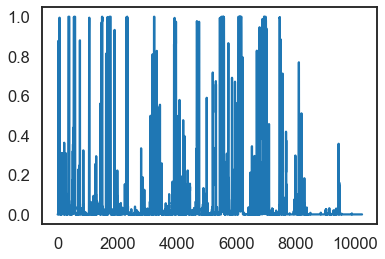

In [61]:
plt.plot(data_tot[0]['data_dict']['beh_labels'][:,5])

## load regression model

In [4]:
# compile models
activity='dFF'
# prune='_prune' #'_noGamma' # set to '' to use full
model_fit_tot = []
model_fit_shifted_tot = []
for nf in range(len(data_tot)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    model_fit_tot.append( pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_'+activity+'_ols_reg_model_whole_3p2_all.pkl', "rb" ) ) )
    #model_fit_shifted_tot.append( pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_'+activity+'_ols_reg_model_shifted_whole_1p0'+prune+'.pkl', "rb" ) ))


### get full and null residuals

In [5]:
reload(reg_model)
# loop over datasets to compile summary dict
summary_dict_tot = []
use_beh_labels = True
# pdb.set_trace()

for nf in range(len(data_tot)):
    # for nf in [0]:
    print(nf,end=' ')
    split_behav = False
    if nf<len(data_tot)-3:
        use_beh_labels=True
    else:
        use_beh_labels=False

    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    data_dict = data_tot[nf]['data_dict']
    model_fit = copy.deepcopy(model_fit_tot[nf])
    model_fit_shifted = [] #copy.deepcopy(model_fit_shifted_tot[nf]) #not needed
    summary_dict_tmp = reg_model.get_summary_dict(expt_id, split_behav, data_dict, model_fit, 
                                                  model_fit_shifted, use_beh_labels)
    summary_dict = {'expt_id':summary_dict_tmp['expt_id'], 'data_dict':summary_dict_tmp['data_dict'],
                    'f':summary_dict_tmp['f'], 'rsq':summary_dict_tmp['rsq']}
    summary_dict_tot.append( summary_dict )
    

0 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
1 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
3 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
4 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
5 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
6 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
7 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
8 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
9 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
10 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
11 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
12 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
13 THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
14 THIS IS THE V

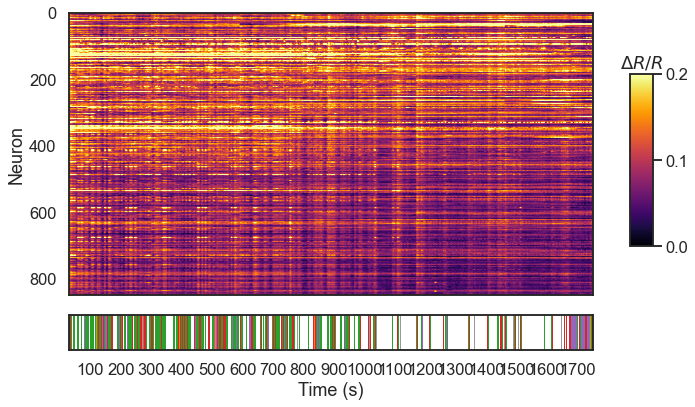

In [6]:
nf=12
reload(plotting)
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
expt_id = summary_dict_tot[nf]['expt_id']
plotting.show_raster_with_behav(summary_dict_tot[nf]['data_dict'],color_range=(0,0.2),
                                split_behavior=False,
                                title='',activity='nobase',sort=False,
                               include_beh_labels=True)
# plt.savefig(fig_dirs['fig_folder']+expt_id +'_raster.pdf',transparent=False, bbox_inches='tight')
plt.show()

In [7]:
# reload(plotting)
# plotting.plot_states_simple(summary_dict_tot[nf]['data_dict'], slc=(3430,4640))
# # plt.savefig(fig_dirs['fig_folder']+expt_id +'_raster_behav_cmap.pdf',transparent=False, bbox_inches='tight')

In [10]:
nf=1
reload(plotting)
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
expt_id = summary_dict_tot[nf]['expt_id']
plotting.show_raster_with_behav(summary_dict_tot[nf]['data_dict'],color_range=(0,0.2),
                                split_behavior=summary_dict_tot[nf]['ro'].params['split_behav'],
                                title='',activity='nobase',sort=False,
                               include_beh_labels=True)
# plt.savefig(fig_dirs['fig_folder']+expt_id +'_residual_raster.pdf',transparent=False, bbox_inches='tight')
plt.show()

KeyError: 'ro'

In [11]:
summary_dict_tot[nf].keys()

dict_keys(['expt_id', 'data_dict', 'f', 'rsq'])

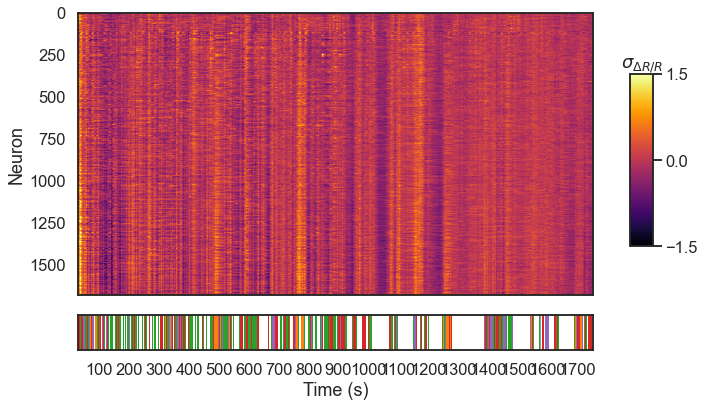

In [11]:
nf=1
reload(plotting)
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
expt_id = summary_dict_tot[nf]['expt_id']
plotting.show_raster_with_behav(summary_dict_tot[nf]['data_dict'],color_range=(-1.5,1.5),
                                split_behavior=False,
                                title='',activity='resid',sort=False,
                               include_beh_labels=True)
# plt.savefig(fig_dirs['fig_folder']+expt_id +'_residual_raster.pdf',transparent=False, bbox_inches='tight')
plt.show()

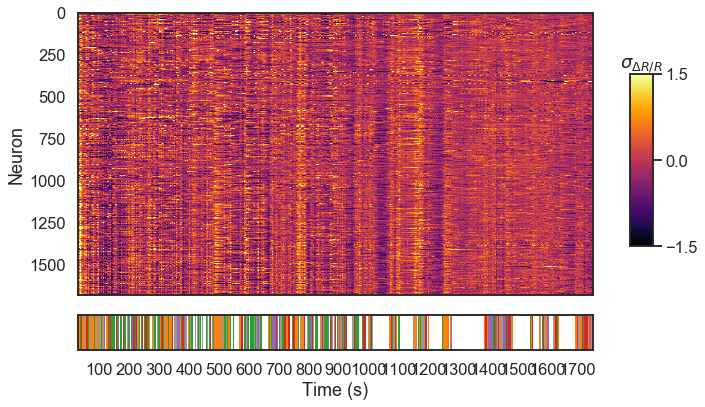

In [12]:
nf=1
reload(plotting)
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
expt_id = summary_dict_tot[nf]['expt_id']
plotting.show_raster_with_behav(summary_dict_tot[nf]['data_dict'],color_range=(-1.5,1.5),
                                split_behavior=False,
                                title='',activity='resid',sort=False,
                               include_beh_labels=True)
# plt.savefig(fig_dirs['fig_folder']+expt_id +'_residual_raster.pdf',transparent=False, bbox_inches='tight')
plt.show()

## look at residual variance vs behaviors

In [12]:
## summarize fit vs behavior stats and behavior stats themselves
r = np.zeros((len(summary_dict_tot)-2, summary_dict_tot[0]['data_dict']['beh_labels'].shape[1]))
for nf in range(len(summary_dict_tot)-2):
    beh = summary_dict_tot[nf]['data_dict']['beh_labels']
    r[nf,:] = beh.sum(axis=0)/beh.shape[0]

reload(plotting)
cmap = plotting.get_state_colors()
colors = cmap.colors
idx = 1+np.array([i for i in range(r.shape[0])])
labels = ['Undefined', 'Stationary', 'Run', 'Front Groom', 'Back Groom', 'Abdomen Bend']

for i in range(len(labels)):
    print('Time spent in '+labels[i],end=' ')
    print(str(r[:,i].mean())+' +/- '+str(r[:,i].std()/np.sqrt(len(r[:,i]))) )


Time spent in Undefined 0.0018326850976157871 +/- 0.0012192899436405686
Time spent in Stationary 0.5007266723648933 +/- 0.051786396887019956
Time spent in Run 0.19607502904628166 +/- 0.03364798754472703
Time spent in Front Groom 0.05127034987163752 +/- 0.007632181372640648
Time spent in Back Groom 0.14411671066043433 +/- 0.029740468047047153
Time spent in Abdomen Bend 0.10564722752208772 +/- 0.013567599760273424


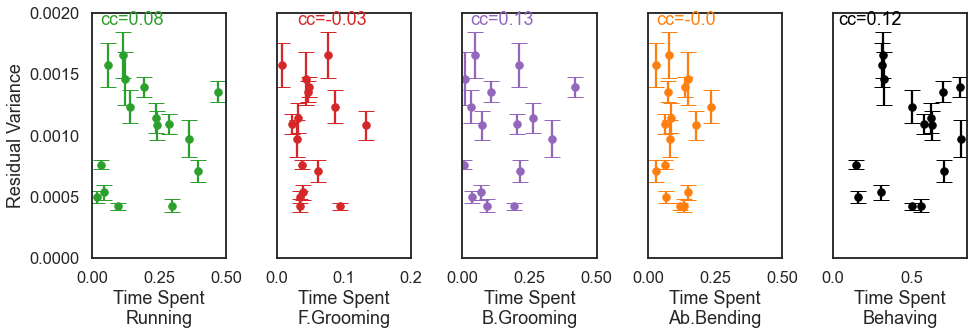

In [13]:
m = np.zeros(len(summary_dict_tot)-2)
s = np.zeros(len(summary_dict_tot)-2)
for nf in range(len(summary_dict_tot)-2):
    v = summary_dict_tot[nf]['data_dict']['dFF_resid_base'].var(axis=1)
    m[nf] = v.mean()
    s[nf] = v.std()/np.sqrt(len(v))

plt.figure(figsize=(14,5)) 
for i in range(2,7):
    plt.subplot(1,5,i-1)
    
    if i<6:
        plt.errorbar(r[:,i], m, yerr=s, color=colors[i],ecolor=colors[i],capsize=8,marker='.',ls='',ms=15)
    else:
        plt.errorbar(r[:,2:].sum(axis=1), m, yerr=s, color='k',ecolor='k',capsize=8,marker='.',ls='',ms=15)
    #plt.title(labels[i])
    
    plt.ylim( 0, .002*np.ceil(500*m.max()) )
    if i>2: plt.yticks([])
    if i==2: 
        plt.xlim(0,.5)
        plt.ylabel('Residual Variance')
        plt.xlabel('Time Spent\nRunning')
    elif i==3:
        plt.xlim(0,.2)
        plt.xlabel('Time Spent\nF.Grooming')
    elif i==4:
        plt.xlim(0,.5)
        plt.xlabel('Time Spent\nB.Grooming')
    elif i==5:
        plt.xlim(0,.5)
        plt.xlabel('Time Spent\nAb.Bending')
    elif i==6:
        plt.xlim(0,.85)
        plt.xlabel('Time Spent\nBehaving')
    if i<6:
        cc=np.round( np.corrcoef(r[:,i], m)[0,1], 2)
        plt.text(.03,.0019,'cc='+str(cc),color=colors[i])
    else:
        cc=np.round( np.corrcoef(r[:,2:].sum(axis=1), m)[0,1], 2)
        plt.text(.03,.0019,'cc='+str(cc),color='k')

plt.tight_layout()
# plt.savefig(dirs['results'] +'_behav_labels_occupancy_vs_res_var.pdf',transparent=True, bbox_inches='tight')


### residual variance vs variance explained by behavior

In [14]:
m0 = np.zeros(len(summary_dict_tot)-2)
s0 = np.zeros(len(summary_dict_tot)-2)
for nf in range(len(summary_dict_tot)-2):
    v = summary_dict_tot[nf]['data_dict']['dFF'].var(axis=1)
    m0[nf] = v.mean()
    s0[nf] = v.std()/np.sqrt(len(v))

In [15]:
mb = np.zeros(len(summary_dict_tot)-2)
sb = np.zeros(len(summary_dict_tot)-2)
for nf in range(len(summary_dict_tot)-2):
    mb[nf] = summary_dict_tot[nf]['rsq']['tot'].mean()
    sb[nf] = summary_dict_tot[nf]['rsq']['tot'].std()/np.sqrt(len(summary_dict_tot[nf]['rsq']['tot']))


### update train/val samples for every dataset

In [8]:
# remake train/test sets (both to be able to repeat and to account for downsampling)
reload(reg_model)
seconds_per_trial = 10 #5 # size of chunks

for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    print(expt_id)

    ror = reg_model.reg_obj(exp_id=expt_id, 
                   data_dict=data_dict,
                   fig_dirs=futils.get_fig_dirs(expt_id))
    ror.get_train_test_data(trial_len=int(seconds_per_trial*data_dict['scanRate']))
    data_dict['train_all'] = ror.data_dict['train_all'].copy()
    data_dict['val_all'] = ror.data_dict['val_all'].copy()
    ror.get_train_test_data(activity='dFF_resid_base', trial_len=int(seconds_per_trial*data_dict['scanRate']))
    data_dict['train_all_res'] = ror.data_dict['train_all'].copy()
    data_dict['val_all_res'] = ror.data_dict['val_all'].copy()
    

2019_07_01_fly2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_08_14_fly1
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_10_10_fly3
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_10_21_fly1
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_08_14_fly3_2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_10_14_fly3
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_10_14_fly4
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_10_18_fly3
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_06_28_fly2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_08_14_fly2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_08_07_fly2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 48
2019_10_02_fly2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of 

### pca on null residual

In [9]:
# trial_len = 160  # length of pseudo-trialsl
# n_trials = np.floor(data_neural.shape[0] / trial_len)
# indxs = split_trials(
#     n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)

In [10]:
n_components = 100
ll_train = np.zeros( (len(exp_list),n_components) )
ll_val = np.zeros( (len(exp_list),n_components) )
var_exp = np.zeros( (len(exp_list),n_components) )

for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    print(expt_id)
    for n in range(n_components):
        pca = PCA(n_components=n+1)
        pca.fit(data_dict['train_all'])
        ll_train[nf,n] = pca.score(data_dict['train_all'])
        ll_val[nf,n] = pca.score(data_dict['val_all'])
    var_exp[nf,:] = np.cumsum(pca.explained_variance_ratio_)

2019_07_01_fly2
2019_08_14_fly1
2019_10_10_fly3
2019_10_21_fly1
2019_08_14_fly3_2
2019_10_14_fly3
2019_10_14_fly4
2019_10_18_fly3
2019_06_28_fly2
2019_08_14_fly2
2019_08_07_fly2
2019_10_02_fly2
2019_08_20_fly3
2019_08_20_fly2
2019_10_14_fly2
2019_10_18_fly2
2018_08_24_fly3_run1
2018_08_24_fly2_run2


In [11]:
ll_max = np.argmax(ll_val, axis=1)
ll_99 = np.zeros((2,len(ll_max)))
for i in range(len(ll_max)):
    ll_99[0,i] = ll_max[i]-np.argmin(abs(ll_val[i,:ll_max[i]] - .99*ll_val[i,ll_max[i]]))
    ll_99[1,i] = np.argmin(abs(ll_val[i,ll_max[i]:] - .99*ll_val[i,ll_max[i]]))

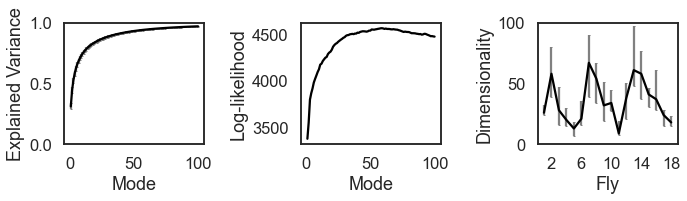

In [12]:
var_exp_m = var_exp.mean(axis=0)
var_exp_sem = np.std(var_exp, axis=0)/np.sqrt(var_exp.shape[0])

plt.figure(figsize=(10, 3))
ax1 = plt.subplot(131)
ax1.errorbar(np.arange(n_components)+1, var_exp_m, yerr=var_exp_sem, color='k',ecolor='gray',capsize=1)

plt.xlabel('Mode')
plt.ylabel('Explained Variance')
plt.ylim(0,1)
plt.xticks([0,50,100])

plt.subplot(132)
plt.plot(np.arange(n_components)+1, ll_val[1,:].T, 'k')
plt.xlabel('Mode')
plt.ylabel('Log-likelihood')
plt.xticks([0,50,100])

ax3 = plt.subplot(133)
ax3.errorbar(np.arange(len(ll_max))+1, ll_max, yerr=ll_99, color='k',ecolor='gray',capsize=1)
plt.xlabel('Fly')
plt.ylabel('Dimensionality')
plt.ylim(0,100)
# plt.yscale('log')
plt.xticks([i for i in range(2,len(ll_max)+1,4)])

plt.tight_layout()
# # plt.savefig(fig_folder + exp_date + '_' + fly_num +'_PC_loglikelihood.pdf',transparent=False, bbox_inches='tight')
# plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_nullResid.pdf',transparent=True, bbox_inches='tight')
plt.show()

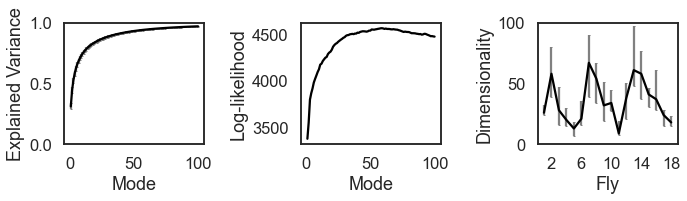

In [13]:
var_exp_m = var_exp.mean(axis=0)
var_exp_sem = np.std(var_exp, axis=0)/np.sqrt(var_exp.shape[0])

plt.figure(figsize=(10, 3))
ax1 = plt.subplot(131)
ax1.errorbar(np.arange(n_components)+1, var_exp_m, yerr=var_exp_sem, color='k',ecolor='gray',capsize=1)

plt.xlabel('Mode')
plt.ylabel('Explained Variance')
plt.ylim(0,1)
plt.xticks([0,50,100])

plt.subplot(132)
plt.plot(np.arange(n_components)+1, ll_val[1,:].T, 'k')
plt.xlabel('Mode')
plt.ylabel('Log-likelihood')
plt.xticks([0,50,100])

ax3 = plt.subplot(133)
ax3.errorbar(np.arange(len(ll_max))+1, ll_max, yerr=ll_99, color='k',ecolor='gray',capsize=1)
plt.xlabel('Fly')
plt.ylabel('Dimensionality')
plt.ylim(0,100)
# plt.yscale('log')
plt.xticks([i for i in range(2,len(ll_max)+1,4)])

plt.tight_layout()
# # plt.savefig(fig_folder + exp_date + '_' + fly_num +'_PC_loglikelihood.pdf',transparent=False, bbox_inches='tight')
# plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_nullResid.pdf',transparent=True, bbox_inches='tight')
plt.show()

### pca on FULL residual

In [14]:
rerun_model = False
n_components = 100

if rerun_model:
    ll_train_res = np.zeros( (len(exp_list),n_components) )
    ll_val_res = np.zeros( (len(exp_list),n_components) )
    var_exp_res = np.zeros( (len(exp_list),n_components) )
    comps = [None]*len(exp_list)
    #eigs = comps = [None]*len(exp_list)

    for nf in range(np.shape(exp_list)[0]):
        expt_id = summary_dict_tot[nf]['expt_id']
        data_dict = summary_dict_tot[nf]['data_dict']
        fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
        print(expt_id)
        for n in range(n_components):
            pca = PCA(n_components=n+1)
            pca.fit(data_dict['train_all_res'])
            ll_train_res[nf,n] = pca.score(data_dict['train_all_res'])
            ll_val_res[nf,n] = pca.score(data_dict['val_all_res'])
        var_exp_res[nf,:] = np.cumsum(pca.explained_variance_ratio_)
        comps[nf] = pca.components_
    d = {'exp_list':exp_list, 'll_train_res':ll_train_res, 
         'll_val_res':ll_val_res, 'var_exp_res':var_exp_res, 'comps':comps }
    pickle.dump(d, open( dirs['data']+'_summary/_behav_resid_PCs.pkl', "wb" ) )
else:
    d = pickle.load( open( dirs['data']+'_summary/_behav_resid_PCs.pkl', "rb" ) )
    ll_train_res = d['ll_train_res']
    ll_val_res = d['ll_val_res']
    var_exp_res = d['var_exp_res']
    comps = d['comps']

In [15]:
# estimate dimensionality using participation ratio of eigenvalues (equivalently, explained variance)
pr_dim = np.zeros(len(exp_list))

for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    pca = PCA(n_components=n_components)
    pca.fit(data_dict['train_all_res'])
    pr_dim[nf] = pca.explained_variance_.sum()**2/np.sum(pca.explained_variance_**2)

In [16]:
# estimate confidence interval for cross-validated dimensionality (+/- 1%)
ll_max_res = np.argmax(ll_val_res, axis=1)
ll_99_res = np.zeros((2,len(ll_max_res)))
for i in range(len(ll_max_res)):
    ll_99_res[0,i] = ll_max_res[i]-np.argmin(abs(ll_val_res[i,:ll_max_res[i]] - .99*ll_val_res[i,ll_max_res[i]]))
    ll_99_res[1,i] = np.argmin(abs(ll_val_res[i,ll_max_res[i]:] - .99*ll_val_res[i,ll_max_res[i]]))

var exp by 10 modes = 0.6197371445856823 +/- 0.01713589397160015
var exp by 11th mode = 0.01856826705815884
Dim by var exp = 13.740266369693446 +/- 1.12909042459931
Dim by Xval = 41.5 +/- 4.612951439984419


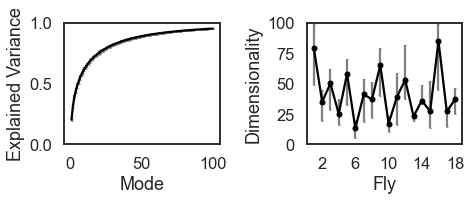

In [17]:
var_exp_m_res = var_exp_res.mean(axis=0)
var_exp_sem_res = np.std(var_exp_res, axis=0)/np.sqrt(var_exp_res.shape[0])

# modes_for_75p = np.argmin(np.abs(var_exp_res-.75),axis=1)
# modes_for_75p_sem = modes_for_75p.std()/np.sqrt(len(modes_for_75p))
# print('Modes for 75% var exp = '+str(modes_for_75p.mean())+' +/- '+str(modes_for_75p_sem))
print('var exp by 10 modes = '+ str(var_exp_res[:,9].mean())+' +/- '+str(var_exp_res[:,9].std()/np.sqrt(var_exp_res.shape[0])))
print('var exp by 11th mode = '+str( var_exp_res[:,10].mean()-var_exp_res[:,9].mean() ))
print('Dim by var exp = '+str(pr_dim.mean())+' +/- '+str(pr_dim.std()/np.sqrt(len(pr_dim))))
print('Dim by Xval = '+str(ll_max_res.mean())+' +/- '+str(ll_max_res.std()/np.sqrt(len(ll_max_res))))

plt.figure(figsize=(7, 3))
ax1 = plt.subplot(121)
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res, yerr=var_exp_sem_res, color='k',ecolor='gray',capsize=1)

plt.xlabel('Mode')
plt.ylabel('Explained Variance')
plt.ylim(0,1)
plt.xticks([0,50,100])

# plt.subplot(132)
# plt.plot(np.arange(n_components)+1, ll_val_res[1,:].T, 'k')
# plt.xlabel('Mode')
# plt.ylabel('Log-likelihood')
# plt.xticks([0,50,100])

ax3 = plt.subplot(122)
ax3.errorbar([i for i in range(len(ll_max_res))], ll_max_res[fly_plot_order], yerr=ll_99_res[:,fly_plot_order], marker='.',markersize=10, color='k',ecolor='gray',capsize=1, label='Dim. by\nX-validation')
# ax3.plot([i for i in range(len(ll_max_res))], ll_max_res, marker='.',markersize=10, color='k')
# ax3.plot([i for i in range(len(ll_max_res))], pr_dim, marker='.',markersize=10, color='tab:cyan', label='Dim. by\nVar. Explained')
plt.xlabel('Fly')
plt.ylabel('Dimensionality')
plt.yticks([0,25,50,75,100])
plt.ylim(0,100)
# plt.yscale('log')
xtks = np.array([i for i in range(1,len(ll_max_res),4)])
plt.xticks(xtks,labels=xtks+1)
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.tight_layout()
# plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_fullResid.pdf',transparent=True, bbox_inches='tight')
plt.show()

var exp by 10 modes = 0.6197371445856823 +/- 0.01713589397160015
var exp by 11th mode = 0.01856826705815884
Dim by var exp = 13.739947781469725 +/- 1.1289598707221669
Dim by Xval = 41.5 +/- 4.612951439984419


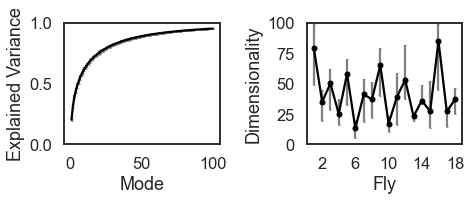

In [16]:
var_exp_m_res = var_exp_res.mean(axis=0)
var_exp_sem_res = np.std(var_exp_res, axis=0)/np.sqrt(var_exp_res.shape[0])

# modes_for_75p = np.argmin(np.abs(var_exp_res-.75),axis=1)
# modes_for_75p_sem = modes_for_75p.std()/np.sqrt(len(modes_for_75p))
# print('Modes for 75% var exp = '+str(modes_for_75p.mean())+' +/- '+str(modes_for_75p_sem))
print('var exp by 10 modes = '+ str(var_exp_res[:,9].mean())+' +/- '+str(var_exp_res[:,9].std()/np.sqrt(var_exp_res.shape[0])))
print('var exp by 11th mode = '+str( var_exp_res[:,10].mean()-var_exp_res[:,9].mean() ))
print('Dim by var exp = '+str(pr_dim.mean())+' +/- '+str(pr_dim.std()/np.sqrt(len(pr_dim))))
print('Dim by Xval = '+str(ll_max_res.mean())+' +/- '+str(ll_max_res.std()/np.sqrt(len(ll_max_res))))

plt.figure(figsize=(7, 3))
ax1 = plt.subplot(121)
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res, yerr=var_exp_sem_res, color='k',ecolor='gray',capsize=1)

plt.xlabel('Mode')
plt.ylabel('Explained Variance')
plt.ylim(0,1)
plt.xticks([0,50,100])

# plt.subplot(132)
# plt.plot(np.arange(n_components)+1, ll_val_res[1,:].T, 'k')
# plt.xlabel('Mode')
# plt.ylabel('Log-likelihood')
# plt.xticks([0,50,100])

ax3 = plt.subplot(122)
ax3.errorbar([i for i in range(len(ll_max_res))], ll_max_res[fly_plot_order], yerr=ll_99_res[:,fly_plot_order], marker='.',markersize=10, color='k',ecolor='gray',capsize=1, label='Dim. by\nX-validation')
# ax3.plot([i for i in range(len(ll_max_res))], ll_max_res, marker='.',markersize=10, color='k')
# ax3.plot([i for i in range(len(ll_max_res))], pr_dim, marker='.',markersize=10, color='tab:cyan', label='Dim. by\nVar. Explained')
plt.xlabel('Fly')
plt.ylabel('Dimensionality')
plt.yticks([0,25,50,75,100])
plt.ylim(0,100)
# plt.yscale('log')
xtks = np.array([i for i in range(1,len(ll_max_res),4)])
plt.xticks(xtks,labels=xtks+1)
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.tight_layout()
# plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_fullResid.pdf',transparent=True, bbox_inches='tight')
plt.show()

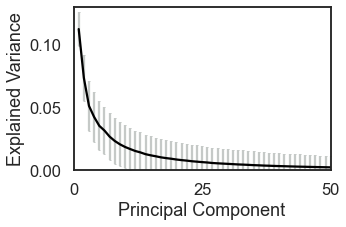

In [18]:
# Individual PC variance explained instead of cumulative
var_exp_m_res = np.diff(var_exp_res.mean(axis=0))
var_exp_sem_res = np.std(var_exp_res, axis=0)/np.sqrt(var_exp_res.shape[0])

plt.figure(figsize=(9, 3.5))
ax1 = plt.subplot(121)
ax1.errorbar(np.arange(n_components-1)+1, var_exp_m_res, yerr=var_exp_sem_res[:-1], color='k',ecolor='#c5c9c7',capsize=1)

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.ylim(0,0.13)
plt.yticks([0,.05,.1])
plt.xticks([0,25,50])
plt.xlim(0,50)

# # plt.subplot(132)
# # plt.plot(np.arange(n_components)+1, ll_val_res[1,:].T, 'k')
# # plt.xlabel('Mode')
# # plt.ylabel('Log-likelihood')
# # plt.xticks([0,50,100])

# ax3 = plt.subplot(122)
# ax3.errorbar([i for i in range(len(ll_max_res))], ll_max_res[fly_plot_order], yerr=ll_99_res[:,fly_plot_order], marker='.',markersize=10, color='k',ecolor='gray',capsize=1, label='Dim. by\nX-validation')
# # ax3.plot([i for i in range(len(ll_max_res))], ll_max_res, marker='.',markersize=10, color='k')
# # ax3.plot([i for i in range(len(ll_max_res))], pr_dim, marker='.',markersize=10, color='tab:cyan', label='Dim. by\nVar. Explained')
# plt.xlabel('Fly')
# plt.ylabel('Dimensionality')
# plt.yticks([0,25,50,75,100])
# plt.ylim(0,100)
# # plt.yscale('log')
# xtks = np.array([i for i in range(1,len(ll_max_res),4)])
# plt.xticks(xtks,labels=xtks+1)
# # plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.tight_layout()
# plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_fullResid_single.pdf',transparent=True, bbox_inches='tight')
plt.show()

### compare reg fit rsq to PCA rsq

In [19]:
rerun_model = False
comp_list = [3,10]

var_exp_all_cells = [None]*len(exp_list) #np.zeros( (len(exp_list),len(comp_list)) )

for nf in range(np.shape(exp_list)[0]):
    # nf=0
    var_exp_all_cells[nf] = [None]*len(comp_list)
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    print(nf,end=' ')
    X = data_dict['train_all_res']
    for n, comps in enumerate(comp_list):
        pca = PCA(n_components=comps+1)
        pca.fit(X)
        X_hat = pca.inverse_transform(pca.transform(X))
        v = X.var(axis=0)
        vhat = (X_hat-X).var(axis=0)
        frac_var_exp = (v-vhat)/v
        var_exp_all_cells[nf][n] = frac_var_exp


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


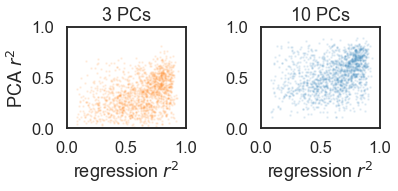

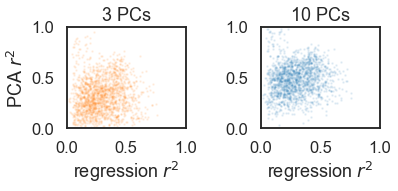

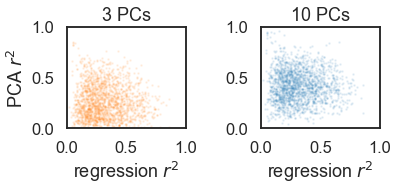

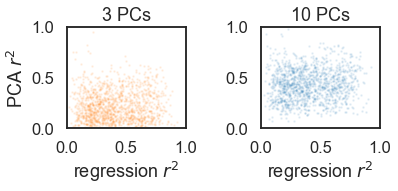

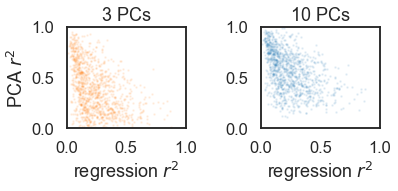

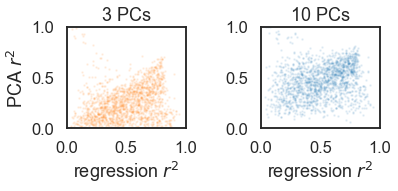

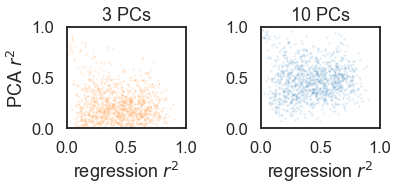

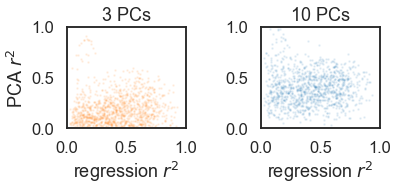

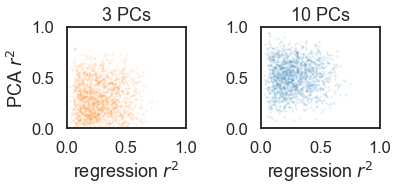

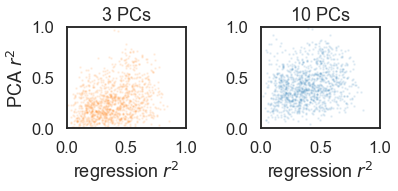

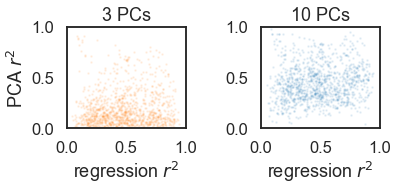

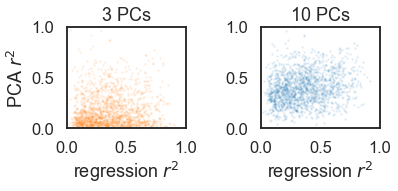

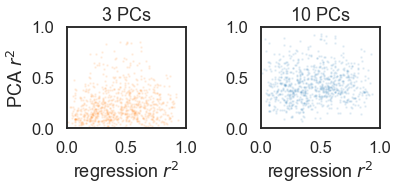

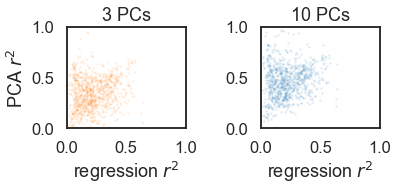

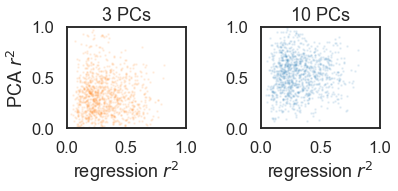

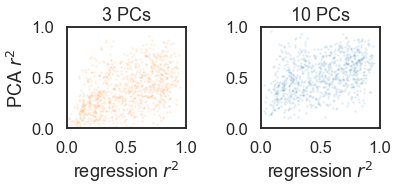

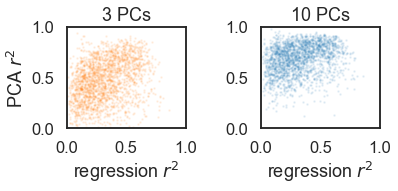

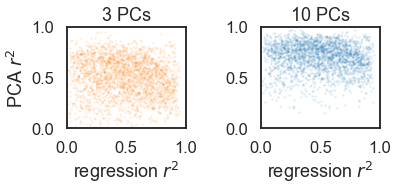

In [27]:
for nf in range(np.shape(exp_list)[0]):
    f = plotting.get_model_fit_as_dict(model_fit_tot[nf])
    rsq = plotting.get_model_fit_as_dict(f['r_sq'])
    
    plt.figure(figsize=(6,3))

    plt.subplot(121)
    plt.scatter(rsq['tot'], var_exp_all_cells[nf][0],s=1,alpha=.1,color='tab:orange')    
    plt.subplot(122)
    plt.scatter(rsq['tot'], var_exp_all_cells[nf][1],s=1,alpha=.1,color='tab:blue')  
    
    plt.subplot(121)
    plt.xlabel(r'regression $r^2$')
    plt.ylabel(r'PCA $r^2$')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('3 PCs')

    plt.subplot(122)
    plt.xlabel(r'regression $r^2$')
    # plt.ylabel(r'PCA $r^2$')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('10 PCs')
    plt.tight_layout()
    
    expt_id = summary_dict_tot[nf]['expt_id']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    #plt.savefig(fig_dirs['pcfig_folder'] +expt_id+'_var_explained_regTot_vs_PCA_onRes.pdf', bbox_inches='tight')


In [20]:
# plt.figure(figsize=(6,3))
pca_rsq_all_3pcs = np.array([])
pca_rsq_all_10pcs = np.array([])
reg_rsq_all = np.array([])
for nf in range(np.shape(exp_list)[0]):
    f = plotting.get_model_fit_as_dict(model_fit_tot[nf])
    rsq = plotting.get_model_fit_as_dict(f['r_sq'])
    
    reg_rsq_all = np.append(reg_rsq_all, rsq['tot'])
    pca_rsq_all_3pcs = np.append(pca_rsq_all_3pcs, var_exp_all_cells[nf][0])
    pca_rsq_all_10pcs = np.append(pca_rsq_all_10pcs, var_exp_all_cells[nf][1])
    

In [21]:
# statistical tests for fig S4

from scipy import stats
print('3 PCs (r and p)')
print(stats.pearsonr(reg_rsq_all, pca_rsq_all_3pcs))
print('\n10 PCs (r and p)')
print(stats.pearsonr(reg_rsq_all, pca_rsq_all_10pcs))

3 PCs (r and p)
(0.05589808436585225, 5.795124126351397e-19)

10 PCs (r and p)
(0.08900598758911331, 1.1855105840667268e-45)


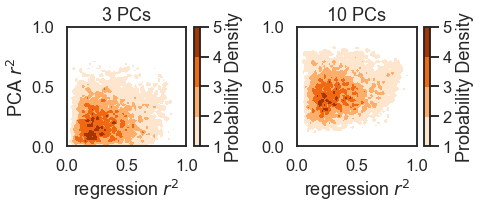

In [22]:
# make fig S4

nbins = 50
h1, xedges, yedges, image = plt.hist2d(reg_rsq_all, pca_rsq_all_3pcs, bins=nbins, density=True)
plt.close()
yi1, xi1 = np.meshgrid(xedges[:-1], yedges[:-1])

h2, xedges, yedges, image = plt.hist2d(reg_rsq_all, pca_rsq_all_10pcs, bins=nbins, density=True)
plt.close()
yi2, xi2 = np.meshgrid(xedges[:-1], yedges[:-1])

plt.figure(figsize=(7,3.25))
plt.subplot(121)
plt.contourf(xi1,yi1,h1,levels=[1,2,3,4,5],cmap='Oranges')
plt.colorbar(label='Probability Density')
plt.xlabel(r'regression $r^2$')
plt.ylabel(r'PCA $r^2$')
plt.xticks([0,.5,1])
plt.yticks([0,.5,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('3 PCs')

plt.subplot(122)
plt.contourf(xi2,yi2,h2,levels=[1,2,3,4,5],cmap='Oranges')
plt.colorbar(label='Probability Density')
plt.xlabel(r'regression $r^2$')
# plt.ylabel(r'PCA $r^2$')
plt.xticks([0,.5,1])
plt.yticks([0,.5,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('10 PCs')
plt.tight_layout()
# plt.savefig(dirs['results'] + '_summary/var_explained_regTot_vs_PCA_onRes.pdf', bbox_inches='tight')


In [158]:
# get candidates for example plots
nf=0
f = plotting.get_model_fit_as_dict(model_fit_tot[nf])
rsq = plotting.get_model_fit_as_dict(f['r_sq'])

expt_id = summary_dict_tot[nf]['expt_id']
data_dict = summary_dict_tot[nf]['data_dict']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
resvar = data_dict['train_all_res'].var(axis=0)

print(np.flatnonzero( (f['tau']<15)*(rsq['tot']>.2)*(resvar>.008)  ))

[  37   57  139  194  211  275  289  392  464  580  797 1054 1274 1281
 1350]


# show un-aligned residual maps

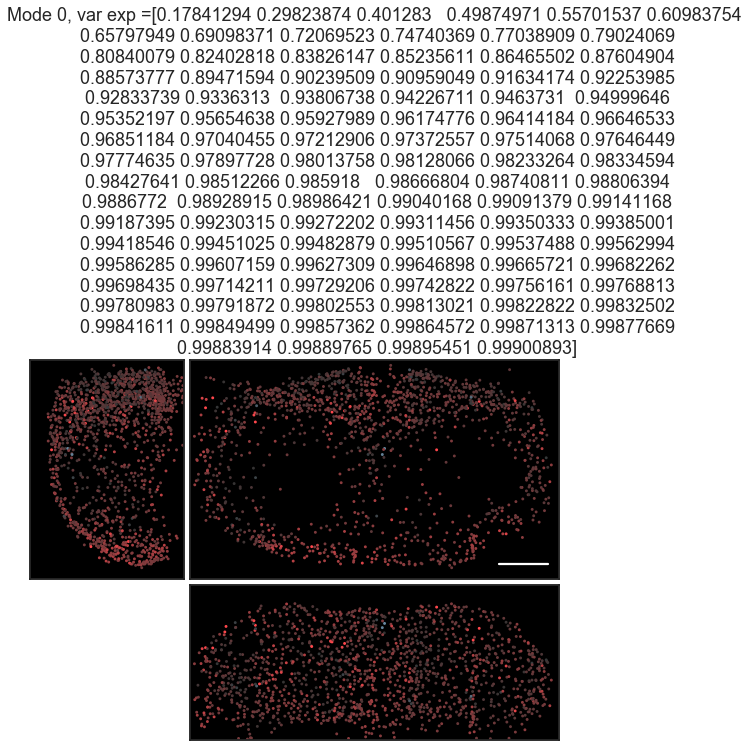

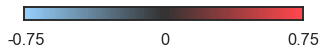

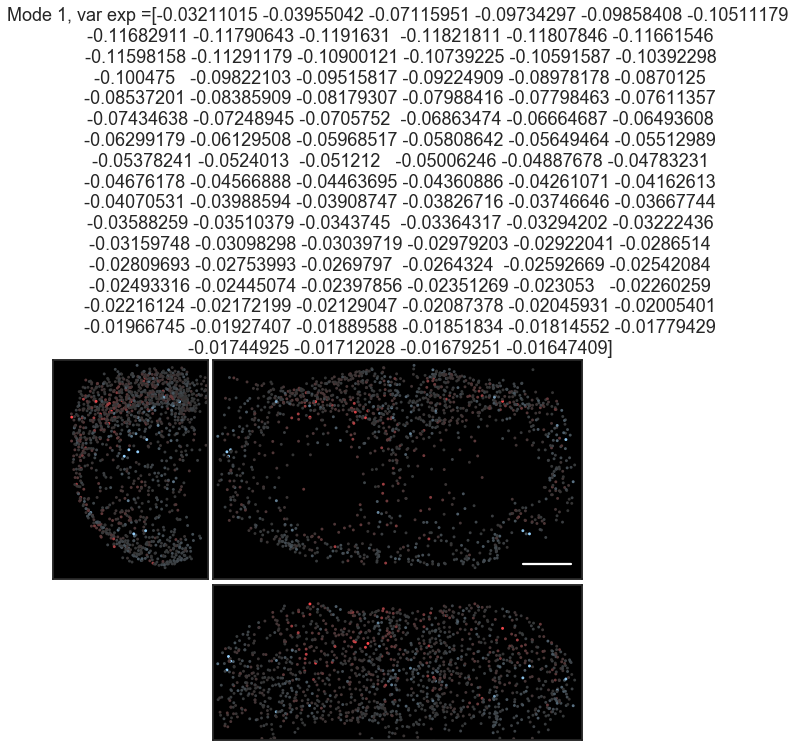

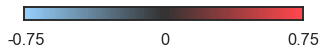

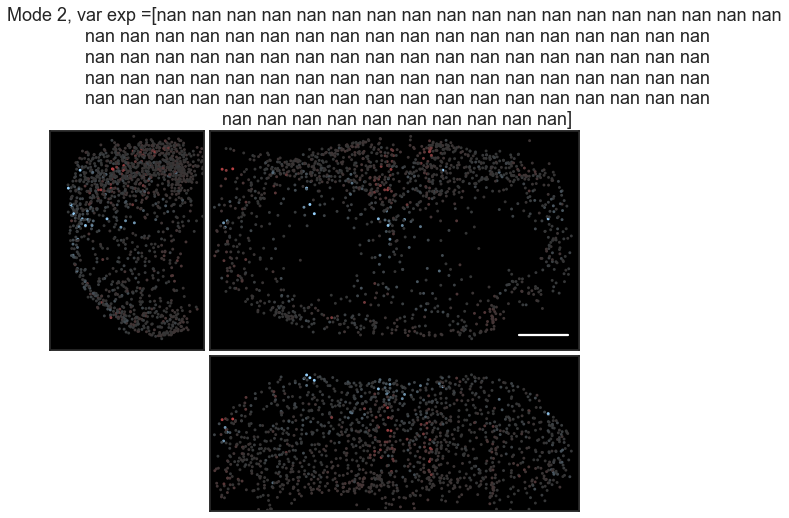

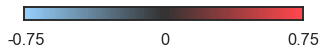

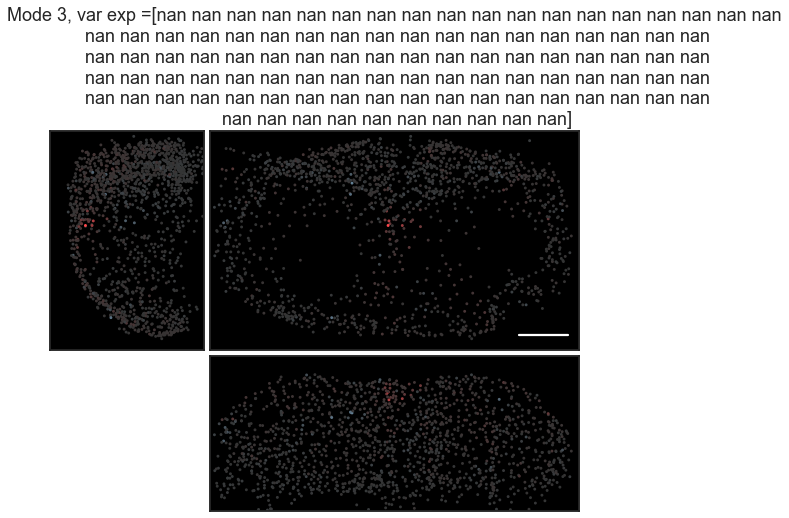

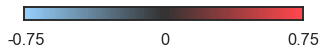

IndexError: index 4 is out of bounds for axis 1 with size 4

In [26]:
reload(plotting)
color_lims_scale=[-.75,.75]

for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    pca = PCA(n_components=n_components)
    pca.fit(data_dict['train_all_res'])

    for nc in range(10):
        plot_param = pca.components_[nc,:]
        
        if nc==0:
            ve = var_exp_res[nf,nc]
        else:
            ve = var_exp_res[nf,nc]-var_exp_res[nf,nc-1]
        title = 'Mode '+str(nc)+', var exp ='+str(ve)
        _ = plotting.show_colorCoded_cellMap_points(data_dict, None, plot_param, cmap=plotting.cold_to_hot_cmap(), pval=0.01, color_lims_scale=color_lims_scale, title=title)
        plt.savefig(fig_dirs['pcfig_folder'] +expt_id+'_ResidMode_'+str(nc+1)+'_map.pdf',transparent=False, bbox_inches='tight')
        
        _ = plotting.cold_to_hot_cmap(show_map=True, tks=[0,50,100], tk_labels=[str(color_lims_scale[0]),'0',str(color_lims_scale[1])])
        plt.savefig(fig_dirs['pcfig_folder'] +expt_id+'_ResidMode_'+str(nc+1)+'_colormap.pdf',transparent=False, bbox_inches='tight')

        plt.show()


### weights shown as line plots

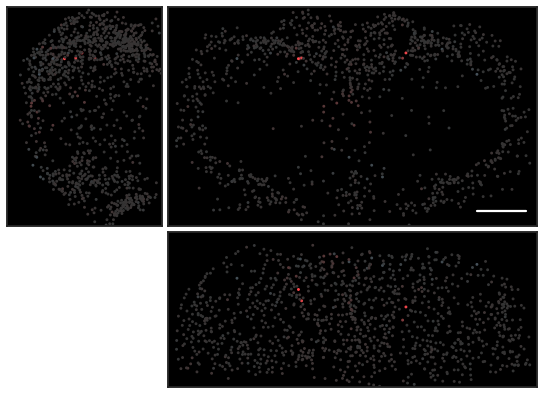

In [23]:
reload(plotting)
color_lims_scale=[-.75,.75]

nf=4
expt_id = summary_dict_tot[nf]['expt_id']
data_dict = summary_dict_tot[nf]['data_dict']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
pca = PCA(n_components=n_components)
pca.fit(data_dict['train_all_res'])

nc=1
plot_param = pca.components_[nc,:]

title = ''
_ = plotting.show_colorCoded_cellMap_points(data_dict, None, plot_param, cmap=plotting.cold_to_hot_cmap(), pval=0.01, color_lims_scale=color_lims_scale, title=title)
    


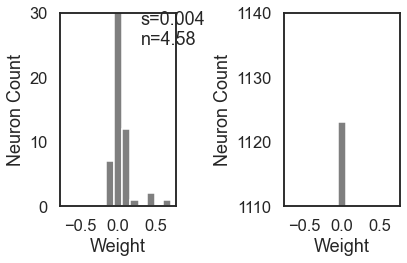

In [24]:
reload(plotting)
color_lims_scale=[-.75,.75]

nf=4
expt_id = summary_dict_tot[nf]['expt_id']
data_dict = summary_dict_tot[nf]['data_dict']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
pca = PCA(n_components=n_components)
pca.fit(data_dict['train_all_res'])

p = pca.components_[1,:].copy()
# tmp = np.logspace(-3,np.log10(0.3),num=12)
# ybins = np.array( (-tmp[::-1]).tolist() + [0] + tmp.tolist() )
ybins = np.linspace(-.7,.7,14)
  
plt.figure(figsize=(6,4))
plt.subplot(121)
plt.hist(p, bins=ybins, color='tab:gray')
plt.ylim(0,30)
plt.xlabel('Weight')
plt.ylabel('Neuron Count')
sp = round((  sum(p**2)**2/sum(p**4)  )/len(p),3)
plt.text(.3,25,'s='+str(sp)+'\nn='+str(round(sp*len(p),2)))

plt.subplot(122)
plt.hist(p, bins=ybins, color='tab:gray')
plt.ylim(1110,1140)
plt.xlabel('Weight')
plt.ylabel('Neuron Count')
plt.tight_layout()
# plt.savefig(fig_dirs['pcfig_folder'] +expt_id+'_ResidModes_exHist.pdf',transparent=False, bbox_inches='tight')
plt.show()


# Spatial order of PCs

In [25]:
# for each dataset, pre-compute shuffled distribution up to cutoff number of outliers, identical to clustering
# for each PC, parse into count that is +/- 5stds
# compute spatial score for + & - groups
# compare to product of corresponding shuffled distributions
# also do for combined +/- to account for asymmetric patterns


In [26]:
# example

nf=0 #4
comps=50

expt_id = summary_dict_tot[nf]['expt_id']
data_dict = summary_dict_tot[nf]['data_dict']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
pca = PCA(n_components=comps)
pca.fit(data_dict['train_all_res'])

print(expt_id)
import clustering as flclust
reload(flclust)

2019_07_01_fly2


<module 'clustering' from '../flygenvectors/clustering.py'>

In [27]:
# binarize PCs into pos/neg outliers

theta_std = 5

pos_vals = [None]*pca.components_.shape[0]
neg_vals = [None]*pca.components_.shape[0]
abs_vals = [None]*pca.components_.shape[0]
pos_count = np.zeros(pca.components_.shape[0])
neg_count = np.zeros(pca.components_.shape[0])
abs_count = np.zeros(pca.components_.shape[0])
for i in range(pca.components_.shape[0]):
    p = pca.components_[i,:]
    th = theta_std*np.std(p)
    pos_vals[i] = np.flatnonzero(p>th)
    neg_vals[i] = np.flatnonzero(p<-th)
    abs_vals[i] = np.flatnonzero( np.logical_or(p>th,p<-th))
    pos_count[i] = len(pos_vals[i])
    neg_count[i] = len(neg_vals[i])
    abs_count[i] = len(abs_vals[i])


In [28]:
# dist score for PCs
ftree = flclust.family_tree(data_dict)
pos_dist = ftree.get_dist_score_for_clusters(pos_vals)
neg_dist = ftree.get_dist_score_for_clusters(neg_vals)
abs_dist = ftree.get_dist_score_for_clusters(abs_vals)


../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


In [29]:
# get null distribution

# ftree.evaluate_dists_vs_parent_and_null(parallel=True, max_null_samples=100, mx_clust_size_null=2)

max_null_samples=100 #100
mx_clust_size_null=14

ftree.mean_dist_null_samples = [None]*mx_clust_size_null

for i in range(1,mx_clust_size_null):
    samples = [None]*max_null_samples

    for n in range(max_null_samples):
        #pdb.set_trace()
        samples[n] = ftree.evaluate_dists_null(clust_size=i)
    ftree.mean_dist_null_samples[i] = samples

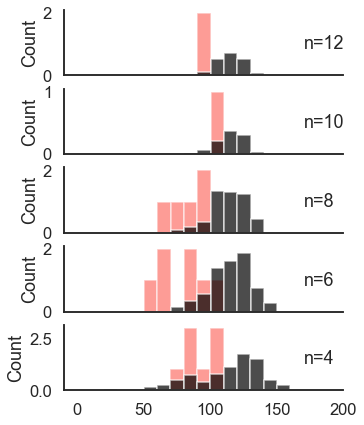

In [30]:
Csize = [12,10,8,6,4]
bins = np.arange(0,200,10)

fig, (ax1) = plt.subplots(nrows=len(Csize), ncols=1, figsize=(5, 7))
for i,c in enumerate(Csize):

    to_plot = np.flatnonzero( (abs_count==c)  )
    clusts_to_plot_abs = abs_dist[to_plot]    

    null_dist = np.array( ftree.mean_dist_null_samples[c] ).flatten()

    ax1[i].hist(clusts_to_plot_abs,bins,color='#fc5a50',alpha=.6,label='true PCs (pos)')
    null_weights = np.ones_like(null_dist) * len(clusts_to_plot_abs)/len(null_dist)
    ax1[i].hist(null_dist,bins,weights=null_weights,color='k',alpha=.7,label='shuffled')
    
    ax1[i].spines['top'].set_visible(False)
    ax1[i].spines['right'].set_visible(False)
    ax1[i].set_ylabel('Count')
    l=ax1[i].get_ylim()
    ax1[i].text(170,l[1]*0.4,'n='+str(c))

    if i==len(Csize)-1:
        ax1[i].set_xticks([0,50,100,150,200])
    else:
        ax1[i].set_xticks([])

## Summary

In [31]:
import clustering as flclust
reload(flclust)

comps=20
theta_std = 5
max_null_samples=100 #100
mx_clust_size_null=14
Csize = [8,6,4]
bins = np.arange(0,200,10)

clusts_to_plot_abs_tot = [None]*mx_clust_size_null
null_dist_tot = [None]*mx_clust_size_null

for nf in range(len(exp_list)):
    print(nf,end=' ')
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    pca = PCA(n_components=comps)
    pca.fit(data_dict['train_all_res'])

    # binarize PCs into pos/neg outliers
    pos_vals = [None]*pca.components_.shape[0]
    neg_vals = [None]*pca.components_.shape[0]
    abs_vals = [None]*pca.components_.shape[0]
    pos_count = np.zeros(pca.components_.shape[0])
    neg_count = np.zeros(pca.components_.shape[0])
    abs_count = np.zeros(pca.components_.shape[0])
    for i in range(pca.components_.shape[0]):
        p = pca.components_[i,:]
        th = theta_std*np.std(p)
        pos_vals[i] = np.flatnonzero(p>th)
        neg_vals[i] = np.flatnonzero(p<-th)
        abs_vals[i] = np.flatnonzero( np.logical_or(p>th,p<-th))
        pos_count[i] = len(pos_vals[i])
        neg_count[i] = len(neg_vals[i])
        abs_count[i] = len(abs_vals[i])
        
    # dist score for PCs
    ftree = flclust.family_tree(data_dict)
    pos_dist = ftree.get_dist_score_for_clusters(pos_vals)
    neg_dist = ftree.get_dist_score_for_clusters(neg_vals)
    abs_dist = ftree.get_dist_score_for_clusters(abs_vals)

    # get null distribution
    ftree.mean_dist_null_samples = [None]*mx_clust_size_null
    for i in range(1,mx_clust_size_null):
        samples = [None]*max_null_samples
        for n in range(max_null_samples):
            samples[n] = ftree.evaluate_dists_null(clust_size=i)
        ftree.mean_dist_null_samples[i] = samples
        
    # compile summary
    for i,c in enumerate(Csize):

        to_plot = np.flatnonzero( (abs_count==c)  )
        clusts_to_plot_abs = abs_dist[to_plot]    
        null_dist = np.array( ftree.mean_dist_null_samples[c] ).flatten()

        if clusts_to_plot_abs_tot[c] is None:
            clusts_to_plot_abs_tot[c] = clusts_to_plot_abs
        else:
            clusts_to_plot_abs_tot[c] = np.append(clusts_to_plot_abs_tot[c],clusts_to_plot_abs)
        if null_dist_tot[c] is None:
            null_dist_tot[c] = null_dist
        else:
            null_dist_tot[c] = np.append(null_dist_tot[c],null_dist)

0 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


1 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


2 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


3 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


4 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


5 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


6 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


7 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


8 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


9 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


10 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


11 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


12 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


13 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


14 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


15 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


16 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


17 

../flygenvectors/clustering.py:691: RuntimeWarning: Mean of empty slice
  return np.nanmean(D)


No handles with labels found to put in legend.


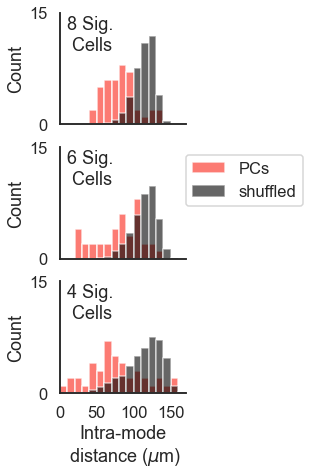

In [41]:
# show summary 

fig, (ax1) = plt.subplots(nrows=len(Csize), ncols=1, figsize=(2.25, 7))
for i,c in enumerate(Csize):

    ax1[i].hist(clusts_to_plot_abs_tot[c],bins,color='#fc5a50',alpha=.8,label='PCs')
    null_weights = np.ones_like(null_dist_tot[c]) * len(clusts_to_plot_abs_tot[c])/len(null_dist_tot[c])
    ax1[i].hist(null_dist_tot[c],bins,weights=null_weights,color='k',alpha=.6,label='shuffled')
    
    ax1[i].spines['top'].set_visible(False)
    ax1[i].spines['right'].set_visible(False)
    ax1[i].set_ylabel('Count')
    ax1[i].set_xlim(0,170)
    l=ax1[i].get_ylim()
    ax1[i].text(10,10,str(c)+' Sig.\n Cells')
    ax1[i].set_yticks([0,15])

    if i==len(Csize)-1:
        ax1[i].set_xticks([0,50,100,150])
        ax1[i].set_xlabel('Intra-mode\n distance ($\mu$m)')
    else:
        ax1[i].set_xticks([])
        
    ax1[1].legend(bbox_to_anchor=(2, .7), loc='right')
    plt.savefig( dirs['results']+'_PC_dist_score_hist_summary.pdf',transparent=True, bbox_inches='tight')


In [35]:
# significance
for i,c in enumerate(Csize):
    print('Size='+str(c))
    print( stats.ks_2samp(clusts_to_plot_abs_tot[c], null_dist_tot[c]) )
    print('\n')

Size=8
Ks_2sampResult(statistic=0.7148238482384823, pvalue=5.358012530064942e-19)


Size=6
Ks_2sampResult(statistic=0.5826608187134503, pvalue=6.683756979569051e-12)


Size=4
Ks_2sampResult(statistic=0.5592063492063493, pvalue=4.684903187339586e-12)




# Mode Sparseness (participation ratio)

In [44]:
n_components = 50
NP = n_components
participation = np.zeros((len(exp_list),NP))

for nf in range(len(exp_list)):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    pca = PCA(n_components=n_components)
    pca.fit(data_dict['train_all_res'])
    
    for nc in range(NP):
        v = pca.components_[nc,:]
        participation[nf, nc] = (  sum(v**2)**2/sum(v**4)  )/len(v)

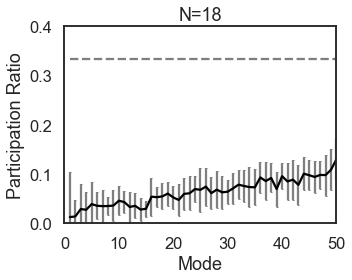

[0.01258169 0.01398104 0.02888888 0.02754745 0.03900208]


In [48]:
### plot participation ratio

# L = list(participation_tot.keys())
# A = np.zeros((len(L), len(participation_tot[L[0]])))
# for i in enumerate(L):
#     A[i[0],:] = participation_tot[i[1]]

m = np.median(participation, axis=0)
s = participation.std(axis=0)
x = [i for i in range(1,NP+1)]

plt.figure(figsize=(5,4))
plt.plot([1,NP],[.333,.333],'--',color='#7d7f7c')
plt.errorbar(x, m, yerr=s,color='k',ecolor='tab:gray',capsize=1)
plt.ylabel('Participation Ratio')
plt.xlabel('Mode')
plt.ylim(0, 0.4)
plt.xlim(0,NP)
# plt.yscale('log',subsy=[.2,.3,.4,.5,.6],basey=10)
# plt.xticks([10,20,30,40])
# print(plt.yticks())
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.title('N='+str(len(exp_list)))
plt.tight_layout()
plt.savefig(dirs['results'] + 'summary_mode_var_explained_fullres.pdf', bbox_inches='tight')
plt.show()
print(m[:5])

# residual from full regression model contains structure

In [398]:
## get total residual (just subtracting drift terms)
nf=0
expt_id = summary_dict_tot[nf]['expt_id']
data_dict = summary_dict_tot[nf]['data_dict']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])

# data_dict['dFF_resid']

### redo the residual plot sorted by similarity to previous row

In [399]:
plot_order = np.zeros(data_dict['dFF_resid'].shape[0])
accounted_for = np.zeros(data_dict['dFF_resid'].shape[0])
last_idx = 0
accounted_for[0] = 1
ctr = 0

while accounted_for.sum()<len(accounted_for):
    if not np.mod(accounted_for.sum(),50): print(int(accounted_for.sum()),end=' ')
    # find the next partner
    argmn = None
    mn = np.inf
    for i in range(len(plot_order)):
        if not accounted_for[i]:
            v = (data_dict['dFF_resid'][last_idx,:]-data_dict['dFF_resid'][i,:]).var()
            if v<mn:
                argmn=i
                mn=v
    
    accounted_for[argmn] = 1
    last_idx=argmn
    ctr += 1
    plot_order[ctr]=argmn
            

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 

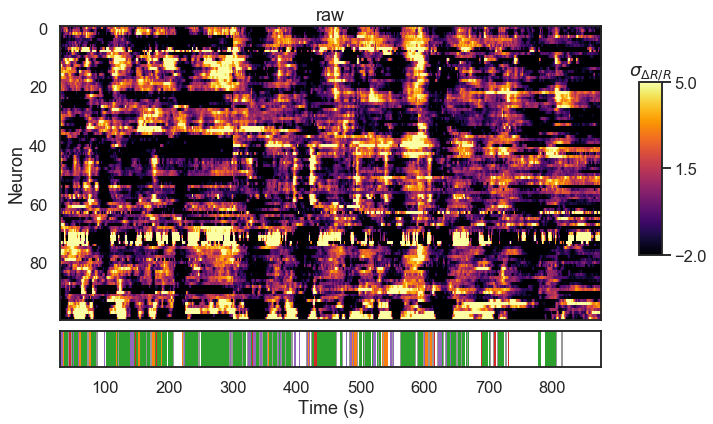

In [405]:
reload(plotting)
# data_dict_res = copy.deepcopy(data_dict)
# data_dict_res['dFF_resid'] = data_dict_res['dFF_resid'][plot_order.astype(int)[105:210],:]
# ax = plotting.show_raster_with_behav(data_dict_res,color_range=(-1,1),
#                                      activity='resid', time_lims=[0,4500], include_beh_labels=True)
# ax[0].set_title('Residual')
# plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_examples.pdf', bbox_inches='tight')
# # plt.show()
#450:550
#1200:1300
neuron_slice = slice(1200,1300) #slice(1150,1250) #slice(450,550)
time_slice = slice(0,5100) #slice(1700,5100)

data_dict_res = copy.deepcopy(data_dict)
data_dict_res['dFF'] = data_dict_res['dFF'][plot_order.astype(int)[neuron_slice],:]
ax = plotting.show_raster_with_behav(data_dict_res,color_range=(-2,5),
                                     activity='std', time_lims=[time_slice.start,time_slice.stop], include_beh_labels=True)
ax[0].set_title('raw')
plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_pre_examples.pdf', bbox_inches='tight')
# plt.show()

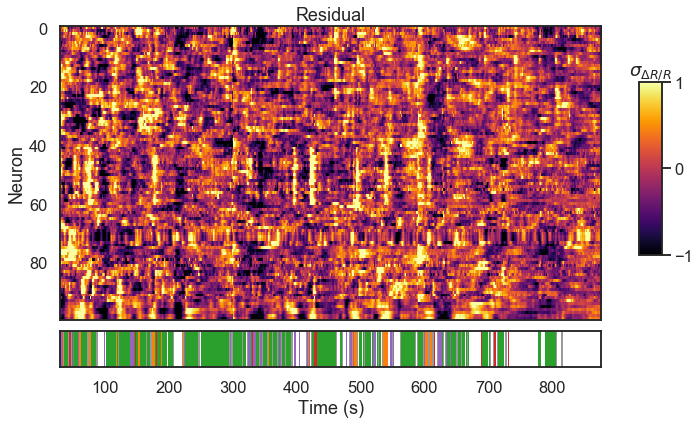

In [406]:
# data_dict_res = copy.deepcopy(data_dict)
# data_dict_res['dFF_resid'] = data_dict_res['dFF_resid'][plot_order.astype(int)[105:210],:]
# ax = plotting.show_raster_with_behav(data_dict_res,color_range=(-1,1),
#                                      activity='resid', time_lims=[0,4500], include_beh_labels=True)
# ax[0].set_title('Residual')
# plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_examples.pdf', bbox_inches='tight')
# # plt.show()
#550:650
data_dict_res = copy.deepcopy(data_dict)
data_dict_res['dFF_resid'] = data_dict_res['dFF_resid'][plot_order.astype(int)[neuron_slice],:]
ax = plotting.show_raster_with_behav(data_dict_res,color_range=(-1,1),
                                     activity='resid', time_lims=[time_slice.start,time_slice.stop], include_beh_labels=True)
ax[0].set_title('Residual')
plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_examples.pdf', bbox_inches='tight')
# plt.show()

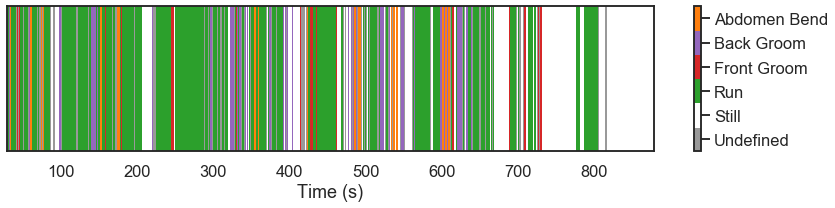

In [407]:
reload(plotting)
plotting.plot_states_simple(data_dict_res)
plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_examples_cmap.pdf', bbox_inches='tight')

### look at examples

[580, 797]


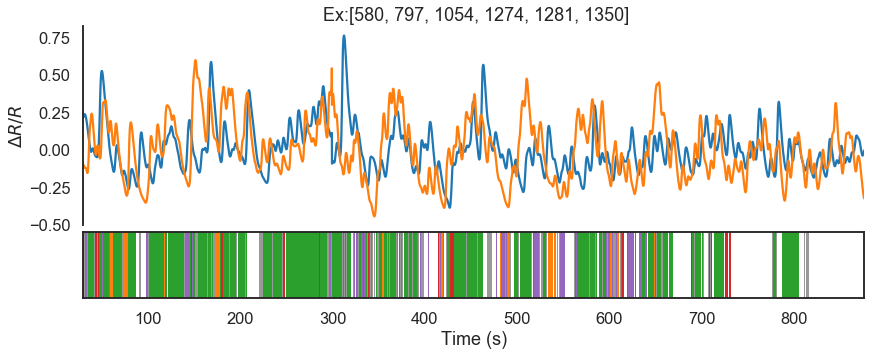

In [455]:
reload(plotting)
n_ex=2
plot_param = [580,  797, 1054, 1274, 1281, 1350] #[i for i in range(93,98)] 
data_dict_res = copy.deepcopy(data_dict)

# data_dict_res['dFF'] = data_dict_res['dFF'][plot_order.astype(int)[neuron_slice],:]
ax = plotting.show_activity_traces(model_fit=None, data_dict=data_dict_res, n_ex=n_ex,
                                   plot_param=plot_param, include_beh_labels=True, slice_time=time_slice)
# ax[0].set_title('Residual')
plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_examples_cell_'+str(plot_param[:n_ex])+'_pre.pdf', bbox_inches='tight')
# plt.show()

[580, 797]


../flygenvectors/plotting.py:320: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


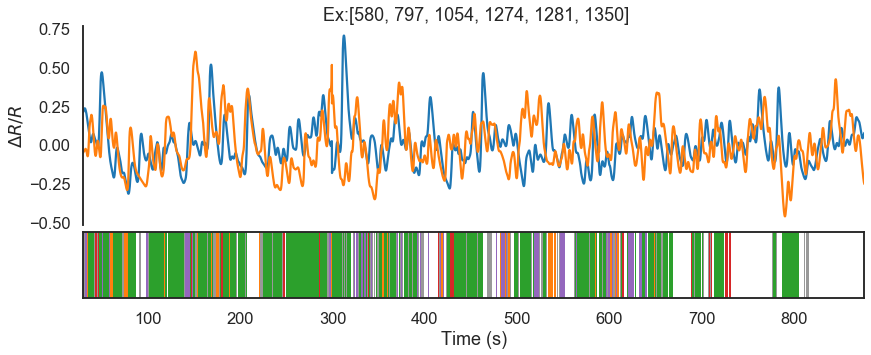

In [458]:
# plot_param = [i for i in range(60,80)]
data_dict_res = copy.deepcopy(data_dict)

data_dict_res['dFF'] = data_dict_res['dFF_resid_base']
# data_dict_res['dFF'] = data_dict_res['dFF_resid'][plot_order.astype(int)[neuron_slice],:]
ax = plotting.show_activity_traces(model_fit=None, data_dict=data_dict_res, n_ex=n_ex,
                                   plot_param=plot_param, include_beh_labels=True, slice_time=time_slice)
# ax[0].set_title('Residual')
plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_residual_examples_cell_'+str(plot_param[0])+'_post.pdf', bbox_inches='tight')
# plt.show()

# Spatial downsampling for alignment

# Aligning dimensions - are there any common patterns?

plan:

- iterated procrustes
- After aligning B to A, for all B & all A, ask whether aligned PCs of B are predictive on held out data

# Dimensionality of running/quiescent subspaces

### prep by making train/test sets FOR EACH BEHAVIOR MOTIF


In [600]:
# summary_dict_tot_orig = copy.deepcopy(summary_dict_tot)

In [629]:
# summary_dict_tot[3]['data_dict'] = copy.deepcopy(summary_dict_tot_orig[3]['data_dict'])

In [48]:
# # test 2019_10_10 trimmed on first 3 trials
# # summary_dict_tot[3]['data_dict']['beh_labels'] = summary_dict_tot[3]['data_dict']['beh_labels'][:4720]
# # summary_dict_tot[3]['data_dict']['dFF_resid_base'] = summary_dict_tot[3]['data_dict']['dFF_resid_base'][:,:4720]
# summary_dict_tot[3]['data_dict']['beh_labels'] = summary_dict_tot[3]['data_dict']['beh_labels'][:6250]
# summary_dict_tot[3]['data_dict']['dFF_resid_base'] = summary_dict_tot[3]['data_dict']['dFF_resid_base'][:,:6250]

In [13]:
nf=0
data_dict = summary_dict_tot[nf]['data_dict']
beh_labels = np.expand_dims(np.argmax(data_dict['beh_labels'],axis=1),axis=1).copy()

In [14]:
# remake train/test sets FOR EACH BEHAVIOR MOTIF
reload(reg_model)
activity='dFF_resid_base' #'dFF' #
seconds_per_trial = 10 #5 # size of chunks
valid_thresh=0.75

for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    print(expt_id)

    tmp = {'train_all':None, 'val_all':None, 'all':None}
    data_dict['dFF_parsed_by_beh_label'] = [tmp.copy() for i in range(4)]
    
    beh_labels = np.expand_dims(np.argmax(data_dict['beh_labels'],axis=1),axis=1).copy()
    not_valid = data_dict['beh_labels'].max(axis=1)<valid_thresh
    beh_labels[not_valid]=0 #assign points with low certainty to "other"

    for i in range(2):
        try:
            behav_flag = np.squeeze(beh_labels)==i+1
            data_dict_tmp = copy.deepcopy(data_dict)
            data_dict_tmp[activity] = data_dict_tmp[activity][:,behav_flag]

            ror = reg_model.reg_obj(exp_id=expt_id, 
                       data_dict=data_dict_tmp,
                       fig_dirs=futils.get_fig_dirs(expt_id))
            ror.get_train_test_data(activity=activity, rng_seed=10000, 
                                    trial_len=int(seconds_per_trial*data_dict['scanRate']))
            data_dict['dFF_parsed_by_beh_label'][i]['train_all'] = ror.data_dict['train_all'].copy()
            data_dict['dFF_parsed_by_beh_label'][i]['val_all'] = ror.data_dict['val_all'].copy()
            data_dict['dFF_parsed_by_beh_label'][i]['all'] = data_dict_tmp[activity].T.copy()
        except:
            print('Not enough examples of label '+str(i))
    

2019_07_01_fly2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
2019_08_14_fly1
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
2019_10_10_fly3
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
Not enough examples of label 1
2019_10_21_fly1
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
2019_08_14_fly3_2
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
Not enough examples of label 1
2019_10_14_fly3
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
THIS IS THE VERSION WITHOUT ABDOMEN BEND AS REG
Number of cores: 16
2019_10_14_fly4
THIS IS 

### PCA on each behavior subspace

In [15]:
def get_frac_var_exp(pca_obj, X):
    # manually compute explained variance for crossed terms
    # n=5
    # pca = PCA(n_components=n)
    # X = data_dict['dFF_parsed_by_beh_label'][l]['train_all'].copy() #np.random.rand(100,1000)
    # X -= X.mean(axis=0)
    # pca.fit(X)
    # print('variance explained: '+str(pca.explained_variance_ratio_.sum()))
    X_hat = pca_obj.inverse_transform(pca_obj.transform(X))
    v = X.var()
    vhat = (X_hat-X).var()
    frac_var_exp = (v-vhat)/v
    return frac_var_exp


In [16]:
# fix mean subtraction
for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    print(expt_id)
    #pdb.set_trace()
    
    # make run and still val same size
    if data_dict['dFF_parsed_by_beh_label'][0]['val_all'] is not None:
        if data_dict['dFF_parsed_by_beh_label'][1]['val_all'] is not None:
            m = min(data_dict['dFF_parsed_by_beh_label'][0]['val_all'].shape[0],data_dict['dFF_parsed_by_beh_label'][1]['val_all'].shape[0])
            data_dict['dFF_parsed_by_beh_label'][0]['val_all'] = data_dict['dFF_parsed_by_beh_label'][0]['val_all'][:m,:]
            data_dict['dFF_parsed_by_beh_label'][1]['val_all'] = data_dict['dFF_parsed_by_beh_label'][1]['val_all'][:m,:]
        
    for l in range(4):
        if data_dict['dFF_parsed_by_beh_label'][l]['val_all'] is not None:
            data_dict['dFF_parsed_by_beh_label'][l]['val_all'] -= data_dict['dFF_parsed_by_beh_label'][l]['val_all'].mean(axis=0)
            data_dict['dFF_parsed_by_beh_label'][l]['train_all'] -= data_dict['dFF_parsed_by_beh_label'][l]['train_all'].mean(axis=0)
            data_dict['dFF_parsed_by_beh_label'][l]['all'] -= data_dict['dFF_parsed_by_beh_label'][l]['all'].mean(axis=0)

2019_07_01_fly2
2019_08_14_fly1
2019_10_10_fly3
2019_10_21_fly1
2019_08_14_fly3_2
2019_10_14_fly3
2019_10_14_fly4
2019_10_18_fly3
2019_06_28_fly2
2019_08_14_fly2
2019_08_07_fly2
2019_10_02_fly2
2019_08_20_fly3
2019_08_20_fly2
2019_10_14_fly2
2019_10_18_fly2
2018_08_24_fly3_run1
2018_08_24_fly2_run2


In [17]:
n_components = 100

# like for like comparisons
ll_train_res = np.nan*np.zeros( (len(exp_list), 4, n_components) )
ll_val_res = np.nan*np.zeros( (len(exp_list), 4, n_components) )
var_exp_res = np.nan*np.zeros( (len(exp_list), 4, n_components) )

# mixed subspace comparisons
ll_val_res_mixed = np.nan*np.zeros( (len(exp_list), 4, n_components) )
var_exp_res_mixed = np.nan*np.zeros( (len(exp_list), 4, n_components) )

for nf in range(len(exp_list)):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    print(expt_id)
    
    for l in range(4):
        if data_dict['dFF_parsed_by_beh_label'][l]['val_all'] is not None:
            for n in range(n_components):
                pca = PCA(n_components=n+1)
                pca.fit(data_dict['dFF_parsed_by_beh_label'][l]['train_all'])
                ll_train_res[nf,l,n] = pca.score(data_dict['dFF_parsed_by_beh_label'][l]['train_all'])
                ll_val_res[nf,l,n] = pca.score(data_dict['dFF_parsed_by_beh_label'][l]['val_all'])
                
                # compare still to running.  Compare running, f.groom, b.groom to still.
                if l==0:
                    if data_dict['dFF_parsed_by_beh_label'][1]['val_all'] is not None:
                        ll_val_res_mixed[nf,l,n] = pca.score(data_dict['dFF_parsed_by_beh_label'][1]['all'])
                        var_exp_res_mixed[nf,l,n] = get_frac_var_exp(pca, data_dict['dFF_parsed_by_beh_label'][1]['all'])
                else:
                    ll_val_res_mixed[nf,l,n] = pca.score(data_dict['dFF_parsed_by_beh_label'][0]['all'])
                    var_exp_res_mixed[nf,l,n] = get_frac_var_exp(pca, data_dict['dFF_parsed_by_beh_label'][0]['all'])
            var_exp_res[nf,l,:] = np.cumsum(pca.explained_variance_ratio_)

2019_07_01_fly2
2019_08_14_fly1
2019_10_10_fly3
2019_10_21_fly1
2019_08_14_fly3_2
2019_10_14_fly3
2019_10_14_fly4
2019_10_18_fly3
2019_06_28_fly2
2019_08_14_fly2
2019_08_07_fly2
2019_10_02_fly2
2019_08_20_fly3
2019_08_20_fly2
2019_10_14_fly2
2019_10_18_fly2
2018_08_24_fly3_run1
2018_08_24_fly2_run2


In [18]:
ll_max_check = ll_val_res.max(axis=2) #get max val to check for nan's
ll_max_res = np.argmax(ll_val_res, axis=2) # argmax is optimal dim, if max is not nan
ll_99_res = np.zeros((4,2,len(ll_max_res)))
for l in range(4):
    for i in range(np.shape(exp_list)[0]):
        if not np.isnan(ll_max_check[i,l]):
            ll_99_res[l,0,i] = ll_max_res[i,l]-np.argmin(abs(ll_val_res[i,l,:ll_max_res[i,l]] - .99*ll_val_res[i,l,ll_max_res[i,l]]))
            ll_99_res[l,1,i] = np.argmin(abs(ll_val_res[i,l,ll_max_res[i,l]:] - .99*ll_val_res[i,l,ll_max_res[i,l]]))

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


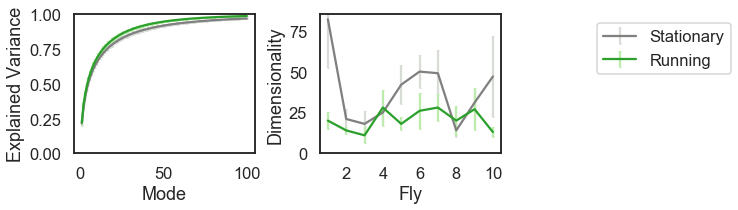

In [21]:
valid_fly = np.logical_not(np.isnan(ll_max_check[:,:2]).sum(axis=1)) # just running and still

var_exp_m_res = np.nanmean(var_exp_res, axis=0)
var_exp_sem_res = np.nanstd(var_exp_res, axis=0)/np.sqrt(var_exp_res.shape[0])

plt.figure(figsize=(11, 3))
ax1 = plt.subplot(121)
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res[0,:], yerr=var_exp_sem_res[0,:].T, color='gray',ecolor='#d8dcd6',capsize=1,label='Stationary')
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res[1,:], yerr=var_exp_sem_res[1,:].T, color='tab:green',ecolor='#bcecac',capsize=1,label='Running')
plt.xlabel('Mode')
plt.ylabel('Explained Variance')
plt.ylim(0,1)
plt.xticks([0,50,100])
# plt.legend()


ax3 = plt.subplot(122)
# err0 = np.zeros((2,sum(valid_fly)))
# err1 = np.zeros((2,sum(valid_fly)))
valid_reordered = valid_fly[fly_plot_order]
err0 = np.squeeze(ll_99_res[0,0,fly_plot_order][valid_reordered])
err1 = np.squeeze(ll_99_res[1,0,fly_plot_order][valid_reordered])

ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[fly_plot_order,0][valid_fly[fly_plot_order]]+1, yerr=err0, color='gray',ecolor='#d8dcd6',capsize=1,label='Stationary')
ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[fly_plot_order,1][valid_fly[fly_plot_order]]+1, yerr=err1, color='tab:green',ecolor='#bcecac',capsize=1,label='Running')
plt.xlabel('Fly')
plt.ylabel('Dimensionality')
# plt.yticks([0,20,40,60])
plt.yticks([0,25,50,75])
plt.ylim(0,85)
xtks = np.array([i for i in range(1,valid_fly.sum(),2)])
plt.xticks(xtks,labels=xtks+1)
plt.legend(bbox_to_anchor=(1.48, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_behavParsed_'+activity+'.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [148]:
stat_dim = (ll_max_res[plot_order,0][valid_fly[plot_order]]+1).mean()
stat_dim_sem = (ll_max_res[plot_order,0][valid_fly[plot_order]]+1).std()/np.sqrt(valid_fly.sum())
run_dim = (ll_max_res[plot_order,1][valid_fly[plot_order]]+1).mean()
run_dim_sem = (ll_max_res[plot_order,1][valid_fly[plot_order]]+1).std()/np.sqrt(valid_fly.sum())

print('Stationary Dim = '+str(round(stat_dim,3))+' +/- '+str(round(stat_dim_sem,3)))
print('Run Dim = '+str(round(run_dim,3))+' +/- '+str(round(run_dim_sem,3)))

Stationary Dim = 36.8 +/- 5.592
Run Dim = 21.0 +/- 2.186


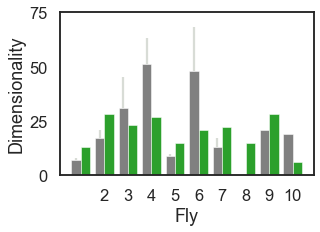

In [134]:
width = 0.4
x_ctrs = np.array([i for i in range(valid_fly.sum())])
err0 = np.zeros((2,sum(valid_fly)))
err1 = np.zeros((2,sum(valid_fly)))
err0[1,:] = np.squeeze(ll_99_res[0,0,valid_fly])
err1[1,:] = np.squeeze(ll_99_res[1,0,valid_fly])

plt.figure(figsize=(10, 3))
ax3 = plt.subplot(122)
ax3.bar(x=x_ctrs-width/2, height=ll_max_res[valid_fly,0], yerr=err0, width=width, color='gray',ecolor='#d8dcd6', linewidth=.5)
ax3.bar(x=x_ctrs+width/2, height=ll_max_res[valid_fly,1], yerr=err1, width=width, color='tab:green',ecolor='#bcecac', linewidth=.5)
plt.yticks([0,25,50,75])
plt.ylim(0,75)
xtks = np.array([i for i in range(1,valid_fly.sum(),2)])
plt.xticks(xtks,labels=xtks+1)
plt.xlabel('Fly')
plt.ylabel('Dimensionality')

plt.savefig('/Users/evan/Downloads/bar_test.pdf',transparent=True, bbox_inches='tight')
plt.show()

### plot trajectories 

In [56]:
n_components = 10

nf=1
# for nf in range(np.shape(exp_list)[0]):
expt_id = summary_dict_tot[nf]['expt_id']
data_dict = summary_dict_tot[nf]['data_dict']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
print(expt_id)

pca_still = PCA(n_components=n+1)
pca_still.fit(data_dict['dFF_parsed_by_beh_label'][0]['train_all'])
pca_run = PCA(n_components=n+1)
pca_run.fit(data_dict['dFF_parsed_by_beh_label'][1]['train_all'])
    
proj_00 = pca_run.transform(data_dict['dFF_parsed_by_beh_label'][0]['all'])
proj_01 = pca_run.transform(data_dict['dFF_parsed_by_beh_label'][1]['all'])
proj_10 = pca_still.transform(data_dict['dFF_parsed_by_beh_label'][0]['all'])
proj_11 = pca_still.transform(data_dict['dFF_parsed_by_beh_label'][1]['all'])
    

2019_08_14_fly1


In [456]:
reload(plotting)
proj_0 = np.concatenate((proj_00,proj_01),axis=0)
proj_1 = np.concatenate((proj_10,proj_11),axis=0)
clr_0 = np.concatenate((np.zeros(proj_00.shape[0]),np.ones(proj_01.shape[0])),axis=0)
clr_1 = np.concatenate((np.zeros(proj_10.shape[0]),np.ones(proj_11.shape[0])),axis=0)

map_cols = ['tab:gray','tab:red']
cmap=LinearSegmentedColormap.from_list('mycmap', map_cols)

fig=plt.figure(figsize=(7, 6))
    
plt.subplot(221)
plotting.plot_pcs(proj_0, color=clr_0, cmap=cmap)
plt.title('proj onto\nstill subspace')
plt.subplot(222)
plotting.plot_pcs(proj_1, color=clr_1, cmap=cmap)
plt.title('proj onto\nrun subspace')


plt.subplot(223)
plotting.plot_pcs(proj_0, color=clr_0, cmap=cmap, idx=[2,3])
plt.subplot(224)
plotting.plot_pcs(proj_1, color=clr_1, cmap=cmap, idx=[2,3])
xl = plt.xlim()
yl = plt.ylim()
plt.text(1.5*xl[1], -.15+yl[0]+(yl[1]-yl[0])/2, 'Running', color='tab:red', size=16)
plt.text(1.5*xl[1], .15+yl[0]+(yl[1]-yl[0])/2, 'Still', color='tab:gray', size=16)

plt.tight_layout()
plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_behav_state_proj.pdf', bbox_inches='tight')
plt.show()


NameError: name 'proj_00' is not defined

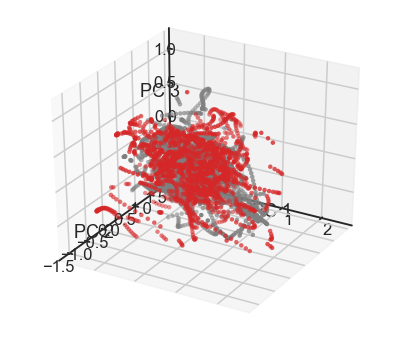

In [75]:
reload(plotting)
proj_0 = np.concatenate((proj_00,proj_01),axis=0)
proj_1 = np.concatenate((proj_10,proj_11),axis=0)
clr_0 = np.concatenate((np.zeros(proj_00.shape[0]),np.ones(proj_01.shape[0])),axis=0)
clr_1 = np.concatenate((np.zeros(proj_10.shape[0]),np.ones(proj_11.shape[0])),axis=0)

map_cols = ['tab:gray','tab:red']
cmap=LinearSegmentedColormap.from_list('mycmap', map_cols)
idx=[0,1,2]

fig=plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
    
ax.scatter(proj_0[:, idx[0]], proj_0[:, idx[1]], proj_0[:, idx[2]], 
           c=clr_0, cmap=cmap, linewidths=0)

xl = ax.get_xlim()
yl = ax.get_ylim()
# plt.text(1.5*xl[1], -.15+yl[0]+(yl[1]-yl[0])/2, 'Running', color='tab:red', size=16)
# plt.text(1.5*xl[1], .15+yl[0]+(yl[1]-yl[0])/2, 'Still', color='tab:gray', size=16)

ax.set_xlabel('PC '+str(idx[0]+1))
ax.set_ylabel('PC '+str(idx[1]+1))
ax.set_zlabel('PC '+str(idx[2]+1))

# ax.set_xticks([-1,1])
# ax.set_yticks([-1,1])
# ax.set_zticks([-2,0])

ax.xaxis._axinfo['juggled'] = (0,0,0)
ax.yaxis._axinfo['juggled'] = (1,1,1)
ax.zaxis._axinfo['juggled'] = (2,2,2)

# plt.tight_layout()
# plt.savefig(fig_dirs['pcfig_folder'] + expt_id +'_behav_state_proj.pdf', bbox_inches='tight')
plt.show()


### crossvalidate across subspaces to see how similar they are

In [149]:
ll_max_check = ll_val_res_mixed.max(axis=2) #get max val to check for nan's
ll_max_res = np.argmax(ll_val_res_mixed, axis=2) # argmax is optimal dim, if max is not nan
ll_99_res = np.zeros((2,2,len(ll_max_res)))
for l in range(2):
    for i in range(len(exp_list)):
        if not np.isnan(ll_max_check[i,l]):
            if ll_max_res[i,l]>0:
                ll_99_res[l,0,i] = ll_max_res[i,l]-np.argmin(abs(ll_val_res[i,l,:ll_max_res[i,l]] - .99*ll_val_res[i,l,ll_max_res[i,l]]))
            ll_99_res[l,1,i] = np.argmin(abs(ll_val_res[i,l,ll_max_res[i,l]:] - .99*ll_val_res[i,l,ll_max_res[i,l]]))

In [150]:
# normalize variance explained in mixed case by same quantity in like for like case
var_exp_res_mixed_ratio = var_exp_res_mixed/var_exp_res

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


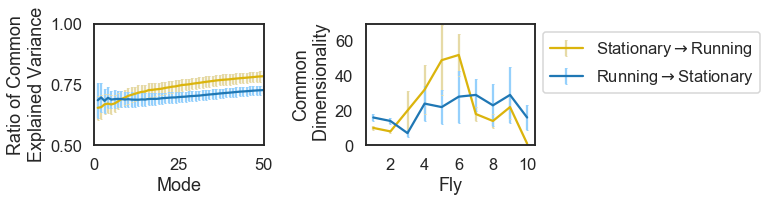

In [193]:
valid_fly = np.logical_not(np.isnan(ll_max_check[:,:2]).sum(axis=1)) # just running and still

var_exp_m_res = np.nanmean(var_exp_res_mixed_ratio, axis=0)
var_exp_sem_res = np.nanstd(var_exp_res_mixed_ratio, axis=0)/np.sqrt(var_exp_res_mixed_ratio.shape[0])

plt.figure(figsize=(11, 3))
ax1 = plt.subplot(121)
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res[0,:], yerr=var_exp_sem_res[0,:].T, color='#DBB40C',ecolor='#e6daa6',capsize=1,label=r'Stationary$\rightarrow$Running')
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res[1,:], yerr=var_exp_sem_res[1,:].T, color='tab:blue',ecolor='#95d0fc',capsize=1,label=r'Running$\rightarrow$Stationary')
plt.xlabel('Mode')
plt.ylabel('Ratio of Common\nExplained Variance')
plt.ylim(0.5,1)
plt.yticks([0.5,0.75,1])
plt.xlim(0,50)
plt.xticks([0,25,50])
# plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1)
# err0 = np.squeeze(ll_99_res[0,0,valid_fly])
# err1 = np.squeeze(ll_99_res[1,0,valid_fly])
valid_reordered = valid_fly[fly_plot_order]
err0 = np.squeeze(ll_99_res[0,0,fly_plot_order][valid_reordered])
err1 = np.squeeze(ll_99_res[1,0,fly_plot_order][valid_reordered])

ax3 = plt.subplot(122)
# ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[valid_fly,0]+1, yerr=err0, color='#DBB40C',ecolor='#e6daa6',capsize=1,label=r'Stationary$\rightarrow$Running')
# ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[valid_fly,1]+1, yerr=err1, color='tab:blue',ecolor='#95d0fc',capsize=1,label=r'Running$\rightarrow$Stationary')
ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[plot_order,0][valid_fly[plot_order]]+1, yerr=err0, color='#DBB40C',ecolor='#e6daa6',capsize=1,label=r'Stationary$\rightarrow$Running')
ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[plot_order,1][valid_fly[plot_order]]+1, yerr=err1, color='tab:blue',ecolor='#95d0fc',capsize=1,label=r'Running$\rightarrow$Stationary')

plt.xlabel('Fly')
plt.ylabel('Common\n Dimensionality')
plt.yticks([0,20,40,60])
plt.ylim(0,70)
xtks = np.array([i for i in range(1,valid_fly.sum(),2)])
plt.xticks(xtks,labels=xtks+1)
# plt.xticks([i for i in range(valid_fly.sum())])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.tight_layout()
plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_behavMixed_'+activity+'.pdf',transparent=True, bbox_inches='tight')
plt.show()

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


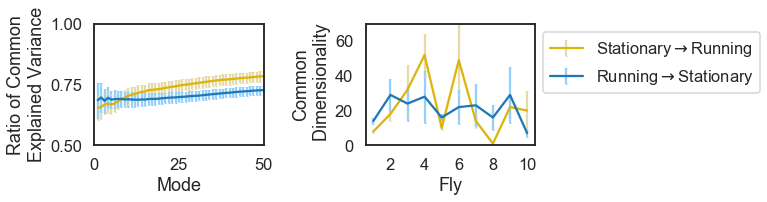

In [181]:
valid_fly = np.logical_not(np.isnan(ll_max_check[:,:2]).sum(axis=1)) # just running and still

var_exp_m_res = np.nanmean(var_exp_res_mixed_ratio, axis=0)
var_exp_sem_res = np.nanstd(var_exp_res_mixed_ratio, axis=0)/np.sqrt(var_exp_res_mixed_ratio.shape[0])

plt.figure(figsize=(11, 3))
ax1 = plt.subplot(121)
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res[0,:], yerr=var_exp_sem_res[0,:].T, color='#DBB40C',ecolor='#e6daa6',capsize=1,label=r'Stationary$\rightarrow$Running')
ax1.errorbar(np.arange(n_components)+1, var_exp_m_res[1,:], yerr=var_exp_sem_res[1,:].T, color='tab:blue',ecolor='#95d0fc',capsize=1,label=r'Running$\rightarrow$Stationary')
plt.xlabel('Mode')
plt.ylabel('Ratio of Common\nExplained Variance')
plt.ylim(0.5,1)
plt.yticks([0.5,0.75,1])
plt.xlim(0,50)
plt.xticks([0,25,50])
# plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1)
# err0 = np.squeeze(ll_99_res[0,0,valid_fly])
# err1 = np.squeeze(ll_99_res[1,0,valid_fly])
err0 = np.squeeze(ll_99_res[0,0,valid_fly])
err1 = np.squeeze(ll_99_res[1,0,valid_fly])

ax3 = plt.subplot(122)
# ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[valid_fly,0]+1, yerr=err0, color='#DBB40C',ecolor='#e6daa6',capsize=1,label=r'Stationary$\rightarrow$Running')
# ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[valid_fly,1]+1, yerr=err1, color='tab:blue',ecolor='#95d0fc',capsize=1,label=r'Running$\rightarrow$Stationary')
ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[:,0][valid_fly]+1, yerr=err0, color='#DBB40C',ecolor='#e6daa6',capsize=1,label=r'Stationary$\rightarrow$Running')
ax3.errorbar([i for i in range(valid_fly.sum())], ll_max_res[:,1][valid_fly]+1, yerr=err1, color='tab:blue',ecolor='#95d0fc',capsize=1,label=r'Running$\rightarrow$Stationary')

plt.xlabel('Fly')
plt.ylabel('Common\n Dimensionality')
plt.yticks([0,20,40,60])
plt.ylim(0,70)
xtks = np.array([i for i in range(1,valid_fly.sum(),2)])
plt.xticks(xtks,labels=xtks+1)
# plt.xticks([i for i in range(valid_fly.sum())])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.tight_layout()
# plt.savefig(dirs['results'] + '_summary/PC_loglikelihood_behavMixed_'+activity+'.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [194]:
statrun_dim = (ll_max_res[plot_order,0][valid_fly[plot_order]]+1).mean()
statrun_dim_sem = (ll_max_res[plot_order,0][valid_fly[plot_order]]+1).std()/np.sqrt(valid_fly.sum())
runstat_dim = (ll_max_res[plot_order,1][valid_fly[plot_order]]+1).mean()
runstat_dim_sem = (ll_max_res[plot_order,1][valid_fly[plot_order]]+1).std()/np.sqrt(valid_fly.sum())

print('Stationary-run Dim = '+str(round(statrun_dim,3))+' +/- '+str(round(statrun_dim_sem,3)))
print('Run-stationary Dim = '+str(round(runstat_dim,3))+' +/- '+str(round(runstat_dim_sem,3)))

Stationary-run Dim = 22.6 +/- 5.09
Run-stationary Dim = 20.8 +/- 2.204


### visualize largest subspace modes

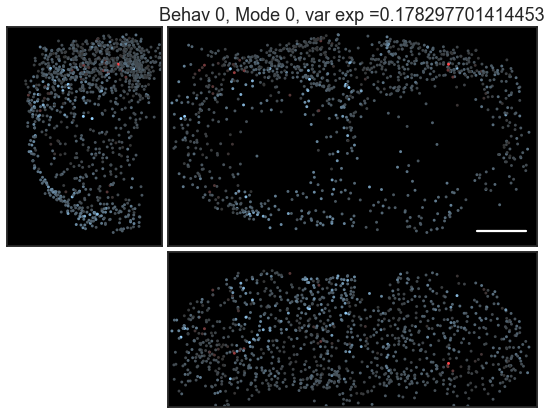

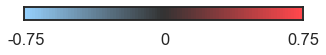

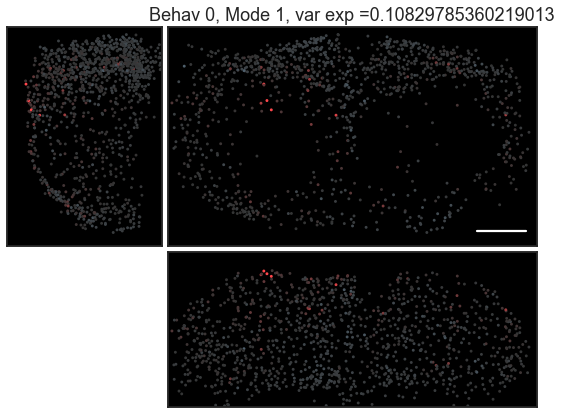

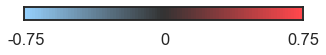

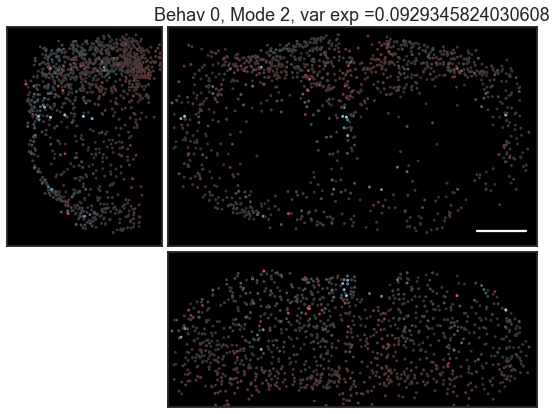

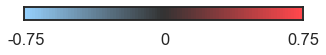

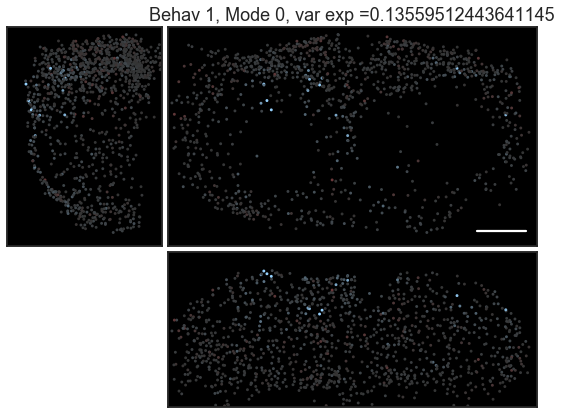

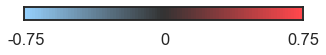

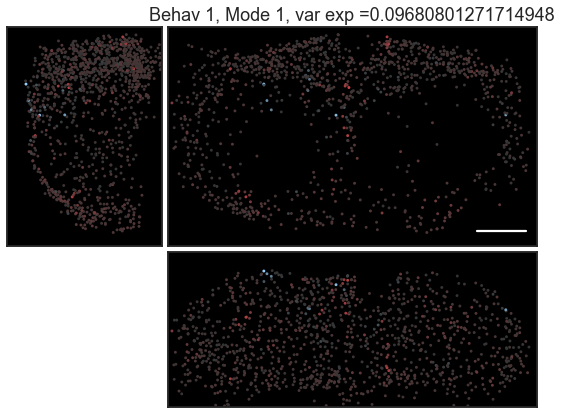

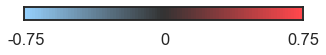

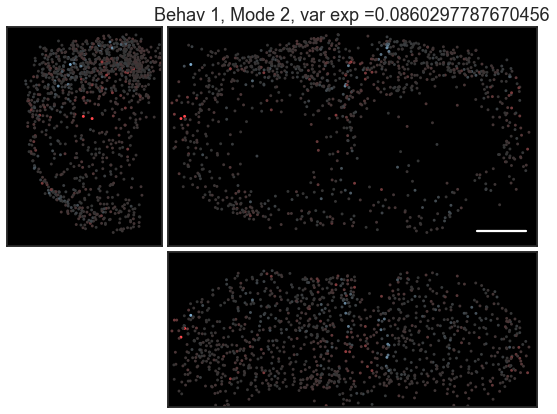

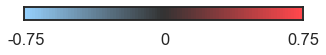

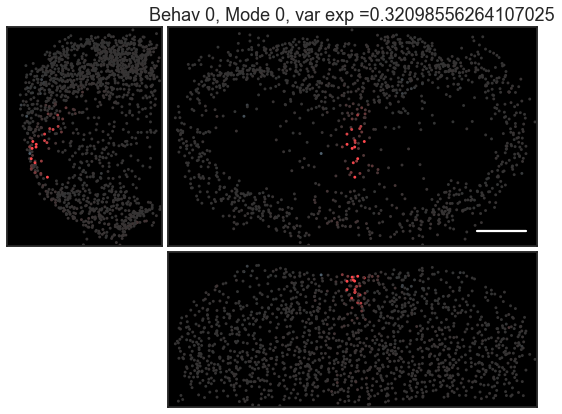

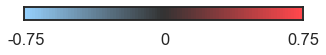

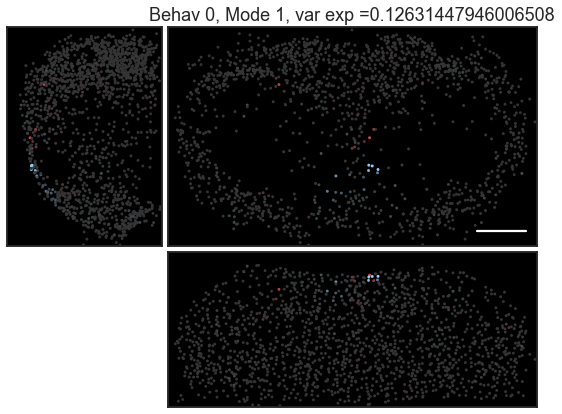

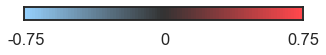

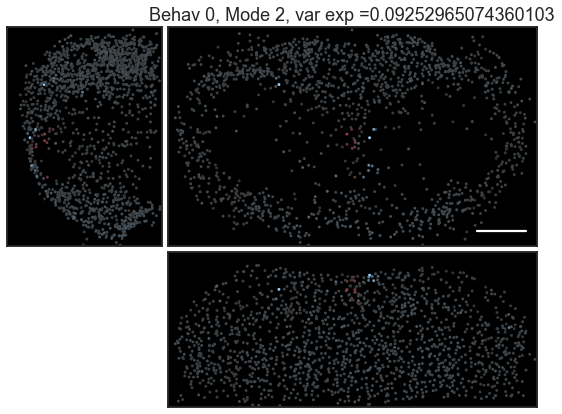

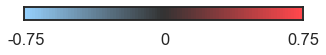

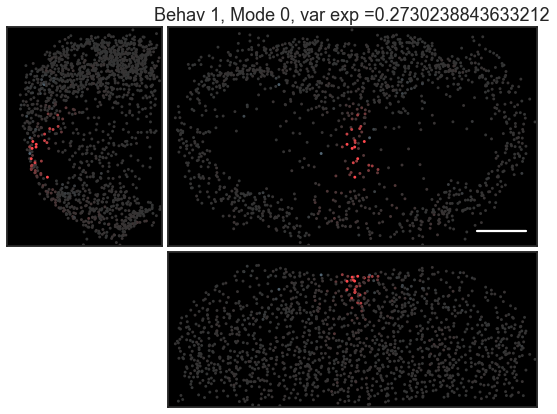

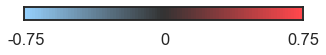

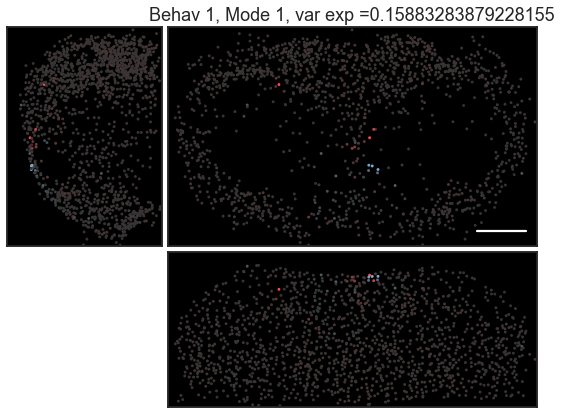

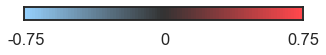

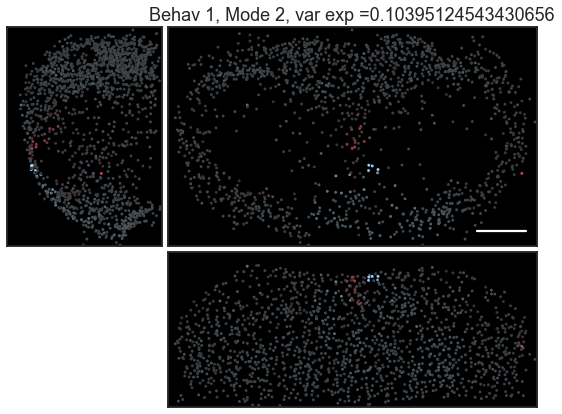

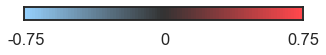

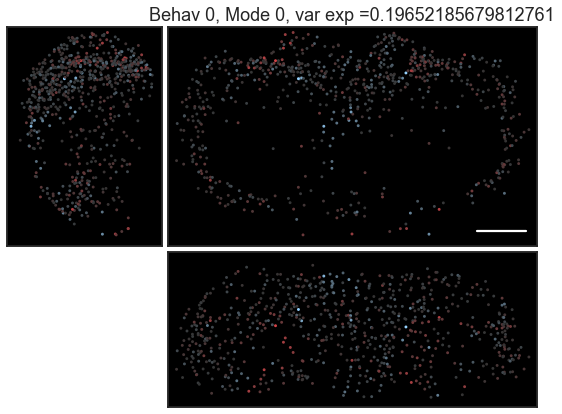

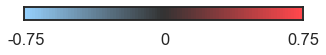

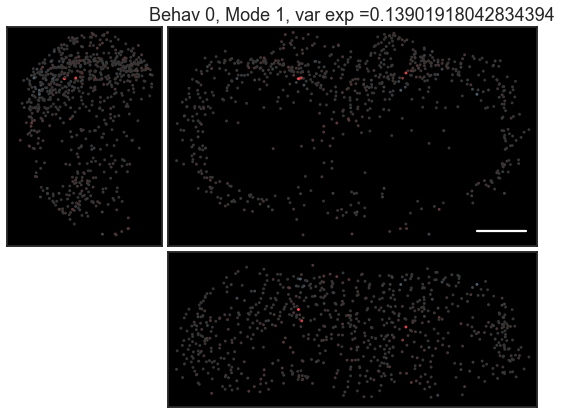

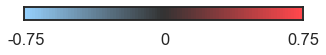

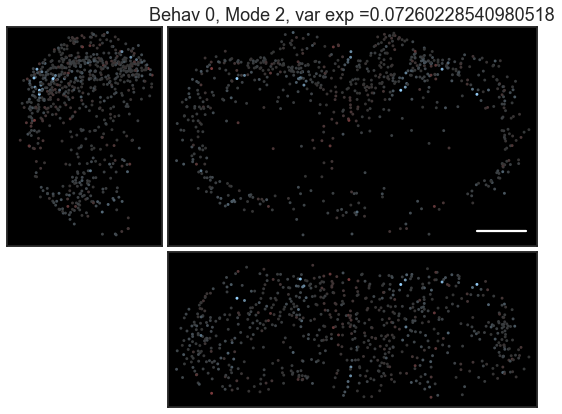

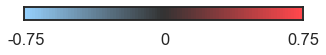

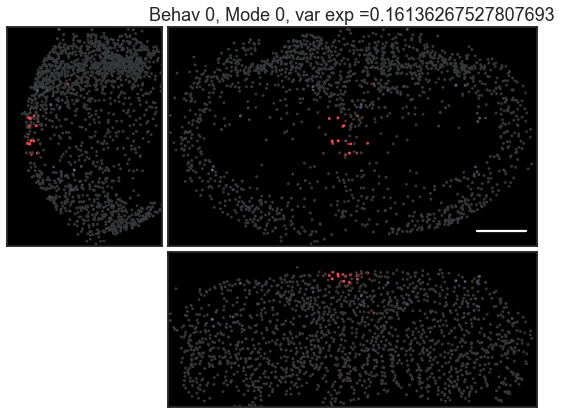

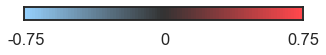

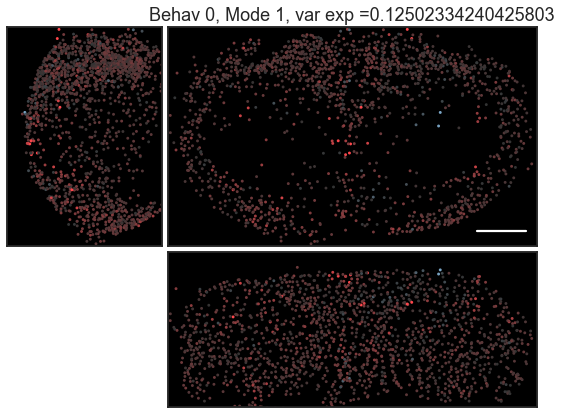

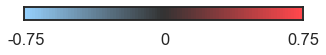

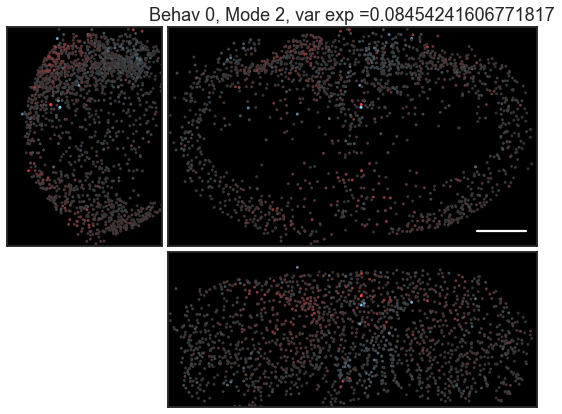

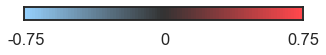

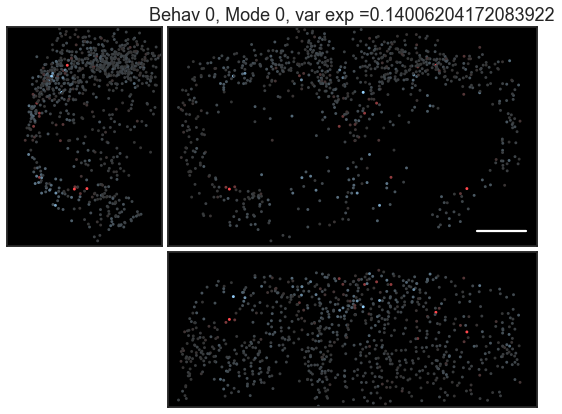

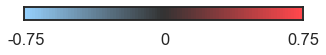

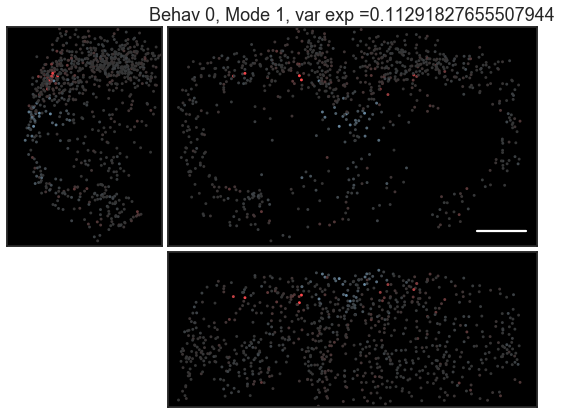

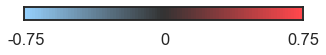

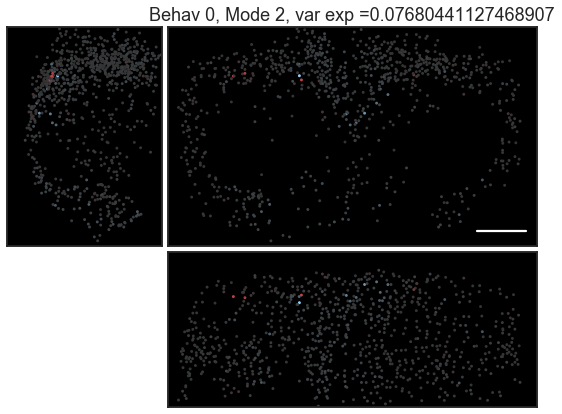

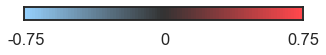

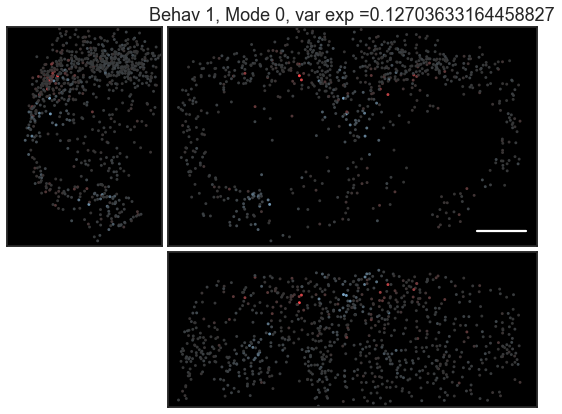

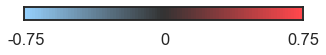

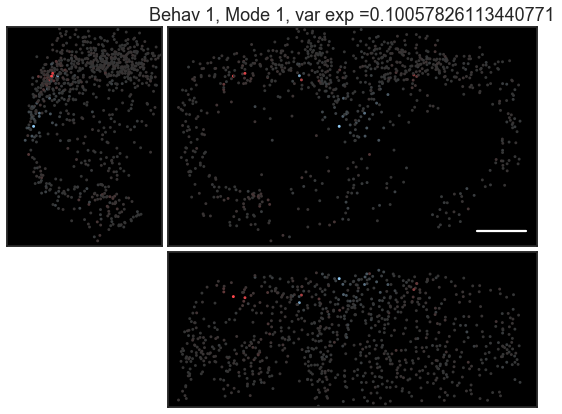

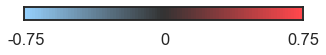

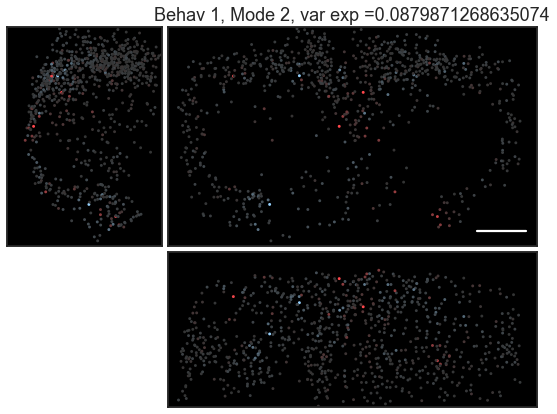

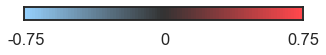

In [657]:
reload(plotting)
color_lims_scale=[-.75,.75]

for nf in range(np.shape(exp_list)[0]):
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
    
    for l in range(2):
        if data_dict['dFF_parsed_by_beh_label'][l]['train_all'] is not None:
            pca = PCA(n_components=n_components)
            pca.fit(data_dict['dFF_parsed_by_beh_label'][l]['train_all'])

            for nc in range(3):
                plot_param = pca.components_[nc,:]

                if nc==0:
                    ve = var_exp_res[nf,l,nc]
                else:
                    ve = var_exp_res[nf,l,nc]-var_exp_res[nf,l,nc-1]
                title = 'Behav '+str(l)+', Mode '+str(nc)+', var exp ='+str(ve)
                _ = plotting.show_colorCoded_cellMap_points(data_dict, None, plot_param, cmap=plotting.cold_to_hot_cmap(), pval=0.01, color_lims_scale=color_lims_scale, title=title)
                plt.savefig(fig_dirs['pcfig_folder'] +expt_id+'_Behav_'+str(l)+'_Mode_'+str(nc+1)+'_map.pdf',transparent=False, bbox_inches='tight')

                _ = plotting.cold_to_hot_cmap(show_map=True, tks=[0,50,100], tk_labels=[str(color_lims_scale[0]),'0',str(color_lims_scale[1])])
                plt.savefig(fig_dirs['pcfig_folder'] +expt_id+'_Behav_'+str(l)+'_Mode_'+str(nc+1)+'_colormap.pdf',transparent=False, bbox_inches='tight')

                plt.show()


# Distribution of correlations in behavioral subspaces

In [162]:
CC_all_cells = [None]*len(exp_list) #np.zeros( (len(exp_list),len(comp_list)) )

for nf in range(np.shape(exp_list)[0]):
    CC_all_cells[nf] = [None]*2
    expt_id = summary_dict_tot[nf]['expt_id']
    data_dict = summary_dict_tot[nf]['data_dict']
    
    if (data_dict['dFF_parsed_by_beh_label'][0]['all'] is not None) and (data_dict['dFF_parsed_by_beh_label'][1]['all'] is not None):
        print(nf,end=' ')
        
        # still
        input_mat = data_dict['dFF_parsed_by_beh_label'][0]['all'].T
        output_mat, _, _ = ror.normalize_rows_euc(input_mat)
        C = output_mat@output_mat.T
        C_still_unrolled = []
        for i in range(C.shape[0]):
            C_still_unrolled.extend(C[i,i+1:])
        CC_all_cells[nf][0] = C_still_unrolled

        # running
        input_mat = data_dict['dFF_parsed_by_beh_label'][1]['all'].T
        output_mat, _, _ = ror.normalize_rows_euc(input_mat)
        C = output_mat@output_mat.T
        C_run_unrolled = []
        for i in range(C.shape[0]):
            C_run_unrolled.extend(C[i,i+1:])
        CC_all_cells[nf][1] = C_run_unrolled
    


0 1 3 5 6 7 10 12 13 15 

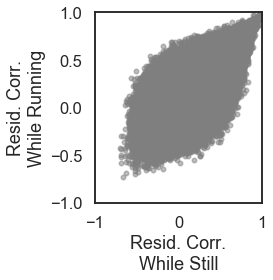

In [168]:
plt.figure(figsize=(4,4))
# for nf in range(np.shape(exp_list)[0]):
nf=0
expt_id = summary_dict_tot[nf]['expt_id']
fig_dirs = futils.get_fig_dirs(summary_dict_tot[nf]['expt_id'])
plt.scatter(CC_all_cells[nf][0], CC_all_cells[nf][1],s=20,alpha=.5,color='tab:gray')       
plt.xlabel('Resid. Corr.\nWhile Still')
plt.ylabel('Resid. Corr.\nWhile Running')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.tight_layout()
plt.savefig(fig_dirs['pcfig_folder'] +expt_id+ '_pairwise_resid_corr_run_vs_still.png', bbox_inches='tight', dpi=300)


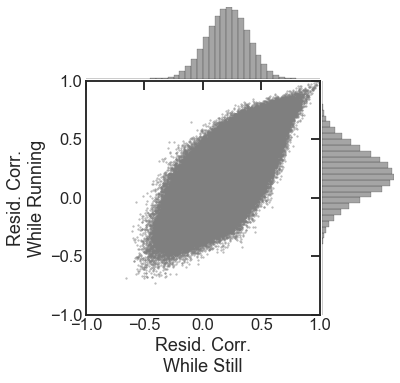

In [169]:
reload(plotting)
nf=0
param_input=['Resid. Corr.\nWhile Still', CC_all_cells[nf][0]]
param2_input=['Resid. Corr.\nWhile Running', CC_all_cells[nf][1]]
plotting.show_param_scatter(model_fit=None, data_dict=None, param_input=param_input, s=10, sig_clr='tab:gray',
                         param2_input=param2_input, xlim=[-1,1], ylim=[-1,1],omit_last_bin=False) #, legend=['Running','Still']
# plt.savefig(dirs['results'] + '_summary/pairwise_resid_corr_by_state.pdf', bbox_inches='tight')


In [172]:
CC_tot_still = []
CC_tot_run = []
for nf in range(np.shape(exp_list)[0]):
    if CC_all_cells[nf][0] is not None:
        CC_tot_still.extend( CC_all_cells[nf][0] )
        CC_tot_run.extend( CC_all_cells[nf][1] )

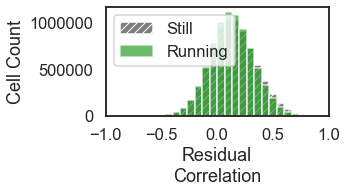

In [173]:
reload(plotting)
param_input=['Residual\nCorrelation', CC_tot_still]
param_input2=['', CC_tot_run]
plotting.show_param_hist(model_fit=None, data_dict=None, param_input=param_input, n_xbins=30,
                         param_input2=param_input2, xlim=[-1,1], sig_clr='tab:green',
                         legend=['Running','Still'], hatch='///')
plt.savefig(dirs['results'] + '_summary/pairwise_resid_corr_by_state.pdf', bbox_inches='tight')


In [180]:
len(CC_tot_run), len(v)

(7998425, 7998425)

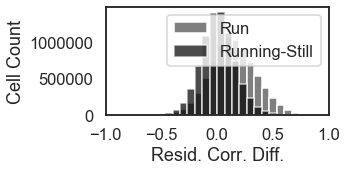

In [181]:
reload(plotting)
v=(np.array(CC_tot_run)-np.array(CC_tot_still)).tolist()
param_input=['Resid. Corr. Diff.', v]
param_input2=['', CC_tot_run]

plotting.show_param_hist(model_fit=None, data_dict=None, param_input=param_input, n_xbins=30,
                         param_input2=param_input2, xlim=[-1,1], sig_clr='k',
                         legend=['Running-Still', 'Run'])
plt.savefig(dirs['results'] + '_summary/pairwise_resid_corr_by_state_diff.pdf', bbox_inches='tight')
